In [179]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from IPython.display import Image, display

from scipy.stats import kurtosis, poisson, chi2_contingency, pearsonr, stats
import scipy.stats as st
import statsmodels.api as sm

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv1D, LSTM, Dense, TimeDistributed, Input,
    BatchNormalization, Bidirectional, Attention, Concatenate
)

from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb


In [180]:
df1 = pd.read_csv('/content/airlines_group1.csv')
#df2 = pd.read_csv('/content/airlines_group2.csv')

In [181]:
df1.head()

date          airline           origin             destination  \
0  2020-10-15  United Airlines    Charlotte, NC          Washington, DC   
1  2020-10-23  United Airlines   Pittsburgh, PA             Houston, TX   
2  2020-10-20  United Airlines   Louisville, KY             Houston, TX   
3  2020-10-20  United Airlines  Little Rock, AR             Houston, TX   
4  2020-10-17  United Airlines   Washington, DC  Sarasota/Bradenton, FL   

  sched_dep_time  actual_dep_time  dep_delay  dep_delay_min  taxi_out  \
0      Afternoon           1444.0       -1.0            0.0      53.0   
1      Afternoon           1611.0       -4.0            0.0       8.0   
2        Morning            700.0        0.0            0.0      29.0   
3        Morning            709.0       -1.0            0.0      59.0   
4        Morning           1153.0       83.0           83.0      10.0   

   taxi_in  ... actual_duration  air_time    dist  dist_group  carrier_delay  \
0      8.0  ...           116.0      55.0   322.0           2            0.0   
1      8.0  ...           213.0     197.0  1117.0           5            0.0   
2      5.0  ...           182.0     148.0   788.0           4            0.0   
3      8.0  ...           129.0      62.0   374.0           2            0.0   
4      2.0  ...           136.0     124.0   849.0           4            0.0   

   weather_delay  nas_delay  security_delay  late_aircraft_delay  week  
0            0.0       19.0             0.0                  0.0    42  
1            0.0       16.0             0.0                  0.0    43  
2            0.0       32.0             0.0                  0.0    43  
3            0.0       29.0             0.0                  0.0    43  
4            0.0       70.0             0.0                  0.0    42  

[5 rows x 25 columns]

# Hypothesis Testing for Airline Data

## 1. Departure Delay Hypothesis
- **H₀ (Null Hypothesis):** The average departure delay (`dep_delay`) is the same across all airlines.  
- **H₁ (Alternative Hypothesis):** At least one airline has a significantly different average departure delay.  

## 2. Arrival Delay and Air Time Relationship
- **H₀:** There is no correlation between air time (`air_time`) and arrival delay (`arr_delay`) across different airlines.  
- **H₁:** There is a significant correlation between air time and arrival delay, varying by airline.  

## 3. Effect of Distance on Delay
- **H₀:** The distance (`dist`) of a flight does not significantly impact departure delay (`dep_delay`) across airlines.  
- **H₁:** Longer distances tend to have higher or lower departure delays, varying by airline.  

## 4. Impact of Carrier Delays on Arrival Delays
- **H₀:** Carrier delays (`carrier_delay`) contribute equally to arrival delay (`arr_delay`) for all airlines.  
- **H₁:** Carrier delays have a significantly different impact on arrival delays for different airlines.  

## 5. Weather Delay Across Airlines
- **H₀:** Weather delays (`weather_delay`) affect all airlines equally.  
- **H₁:** Certain airlines experience more weather delays than others.  


Utilize Linear and Non-Linear (polynomial with degree n) regression models to compare trends for a single Airline and its airports . Start your data from (Monday)2020-10-19 to (Sunday)2023-04-23.

## Weekly trends of arrival and departure delays of united airlines

<ipython-input-182-c1b7d660e31e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_airline['date'] = pd.to_datetime(df_airline['date'])


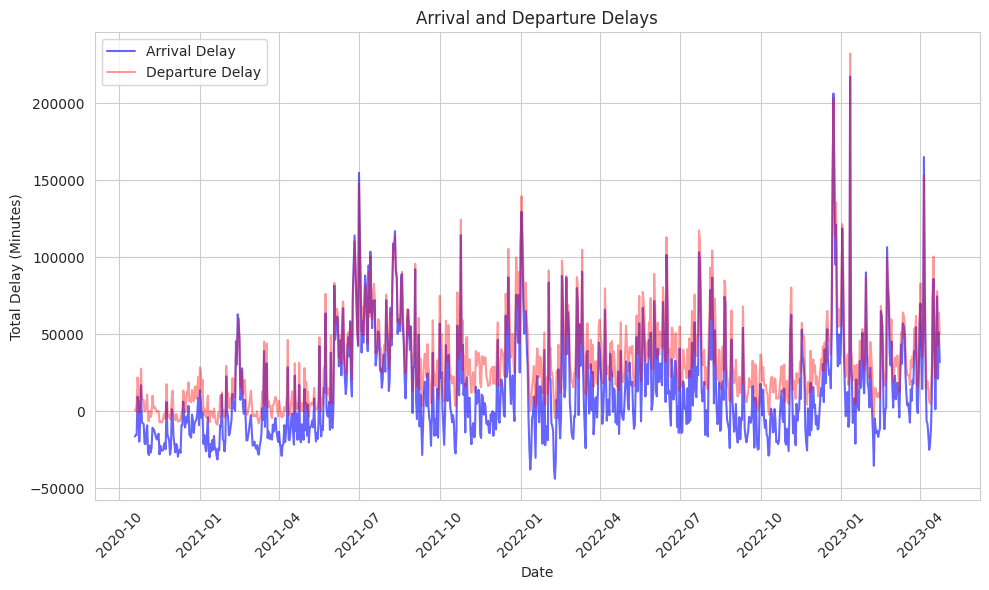

In [182]:
# Filter data for a specific airline (e.g., 'United Airlines')
df_airline = df1[df1['airline'] == 'United Airlines']

# Convert 'date' to datetime
df_airline['date'] = pd.to_datetime(df_airline['date'])

# Filter date range from 2020-10-19 to 2023-04-23
df_airline = df_airline[(df_airline['date'] >= '2020-10-19') & (df_airline['date'] <= '2023-04-23')]

# Group by date and sum arrival and departure delays
delays_by_date = df_airline.groupby('date')[['arr_delay', 'dep_delay']].sum().reset_index()

# Plotting
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Plotting arrival delays
sns.lineplot(data=delays_by_date, x='date', y='arr_delay', label='Arrival Delay', color='blue',alpha=0.6)

# Plotting departure delays
sns.lineplot(data=delays_by_date, x='date', y='dep_delay', label='Departure Delay', color='red',alpha=0.4)

plt.xlabel('Date')
plt.ylabel('Total Delay (Minutes)')
plt.title('Arrival and Departure Delays')

plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


1. **Filter Data for Specific Airline**:
   - The data is filtered to include only records from **"United Airlines"** using the condition:

2. **Convert 'Date' to Datetime**:
   - The `'date'` column is converted to a **datetime format** using `pd.to_datetime()`, allowing time-based operations:

3. **Filter Date Range**:
   - The data is filtered to include only records within the **date range** from **October 19, 2020, to April 23, 2023**:

4. **Group by Date and Calculate Delays**:
   - The data is **grouped by the `'date'` column**, and the **sum of arrival delays (`arr_delay`)** and **departure delays (`dep_delay`)** is calculated for each day:


In [183]:
# Function for calculating RMSE (Root Mean Squared Error)
def rmse_cal(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse


In [184]:
# Function for fitting polynomial regression
def polynomial_reg(X, y, degree):
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X)

    model.fit(X_poly, y)
    return model


In [185]:
# Function for fitting linear regression
def linear_reg(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model


In [186]:
# Function to plot actual vs. predicted values
def plot_results(x_val, y_actual, y_pred, title, xlabel, ylabel, color_actual, color_pred):
    plt.plot(x_val, y_actual, label='Actual values', color=color_actual)
    plt.plot(x_val, y_pred, label='Predicted values', color=color_pred)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()


In [187]:
# Function to plot linear regression results for delays
def plot_linear_regression_results(x_val, y_val1, y_pred_lm_arr, y_val2, y_pred_lm_dep):
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    plt.subplot(221)
    plot_results(x_val, y_val1, y_pred_lm_arr, 'Linear Regression for Arrival Delays', 'Number of Days', 'Arrival Delay (Minutes)', 'blue', 'red')

    plt.subplot(222)
    plot_results(x_val, y_val2, y_pred_lm_dep, 'Linear Regression for Departure Delays', 'Number of Days', 'Departure Delay (Minutes)', 'orange', 'purple')

    plt.tight_layout()
    plt.show()


In [188]:
# Function to plot polynomial regression results for delays
def plot_polynomial_regression_results(x_val, y_val1, y_pred_poly_arr, y_val2, y_pred_poly_dep):
    plt.figure(figsize=(12, 6))

    plt.subplot(223)
    plot_results(x_val, y_val1, y_pred_poly_arr, 'Polynomial Regression for Arrival Delays', 'Number of Days', 'Arrival Delay (Minutes)', 'blue', 'red')

    plt.subplot(224)
    plot_results(x_val, y_val2, y_pred_poly_dep, 'Polynomial Regression for Departure Delays', 'Number of Days', 'Departure Delay (Minutes)', 'orange', 'purple')

    plt.tight_layout()
    plt.show()


In [189]:
x_val = np.arange(len(delays_by_date)).reshape(-1, 1)
y_val1 = delays_by_date['arr_delay']
y_val2 = delays_by_date['dep_delay']


## Linear Regression of arrival and departure delays for United Airlines

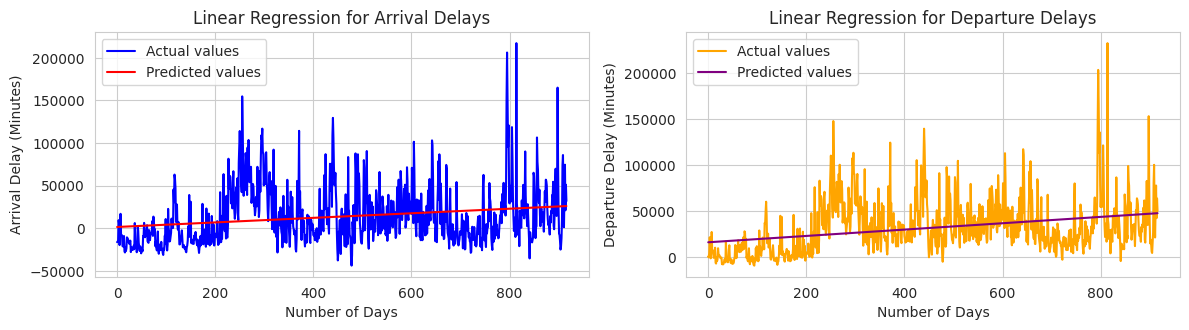

In [190]:
# Fitting linear regression models for arrival and departure delays
lm_arr_delay = linear_reg(x_val, y_val1)
lm_dep_delay = linear_reg(x_val, y_val2)

# Predicting with the models
y_pred_lm_arr = lm_arr_delay.predict(x_val)
y_pred_lm_dep = lm_dep_delay.predict(x_val)

# Calculating RMSE for arrival and departure delays
rmse_lm_arr = rmse_cal(y_val1, y_pred_lm_arr)
rmse_lm_dep = rmse_cal(y_val2, y_pred_lm_dep)
plot_linear_regression_results(x_val, y_val1, y_pred_lm_arr, y_val2, y_pred_lm_dep)

In [191]:
print(f"RMSE for Linear Regression for Arrival Delays: {rmse_lm_arr:.2f}")
print(f"RMSE for Linear Regression for Departure Delays: {rmse_lm_dep:.2f}")


RMSE for Linear Regression for Arrival Delays: 33136.43
RMSE for Linear Regression for Departure Delays: 27594.95


## Polynomial Regression of arrival and departure delays for United Airlines

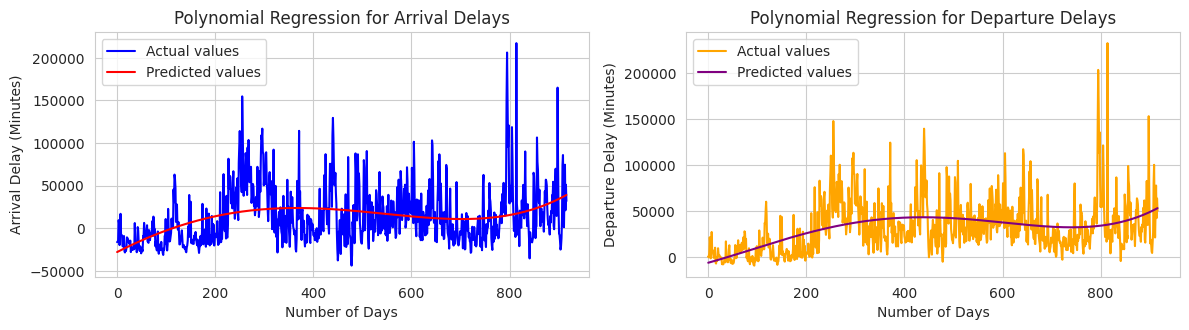

In [192]:
# Fitting polynomial regression models for arrival and departure delays
degree = 4  # Choosing degree 4 for the polynomial
poly = PolynomialFeatures(degree=degree)  # Defining the poly object
X_poly = poly.fit_transform(x_val)

poly_arr_delay = linear_reg(X_poly, y_val1)
poly_dep_delay = linear_reg(X_poly, y_val2)

# Predicting with the models
y_pred_poly_arr = poly_arr_delay.predict(X_poly)
y_pred_poly_dep = poly_dep_delay.predict(X_poly)

# Calculating RMSE for arrival and departure delays
rmse_poly_arr = rmse_cal(y_val1, y_pred_poly_arr)
rmse_poly_dep = rmse_cal(y_val2, y_pred_poly_dep)
# Call the function to plot polynomial regression results
plot_polynomial_regression_results(x_val, y_val1, y_pred_poly_arr, y_val2, y_pred_poly_dep)

In [193]:
print(f"RMSE for Polynomial Regression Arrival Delays: {rmse_poly_arr:.2f}")
print(f"RMSE for Polynomial Regression Departure Delays: {rmse_poly_dep:.2f}")


RMSE for Polynomial Regression Arrival Delays: 31615.28
RMSE for Polynomial Regression Departure Delays: 25936.30


In [194]:
# Filtering data for United Airlines (UA)
UA_df = df1[df1['airline'] == 'United Airlines']

# Calculating the top 5 airports with the highest arrival delays
top_airports = UA_df.groupby('destination')[['arr_delay']].max().sort_values(by='arr_delay', ascending=False).head(5)
top_airport_names = top_airports.index.tolist()

print("List of top 5 airports with the highest arrival delays for United Airlines:")
top_airport_names


List of top 5 airports with the highest arrival delays for United Airlines:


['Denver, CO',
 'Chicago, IL',
 'Newark, NJ',
 'Houston, TX',
 'Colorado Springs, CO']

In [195]:


# Filter top airports and ensure correct data type
df_top_airports = UA_df[UA_df['destination'].isin(top_airport_names)].copy()
df_top_airports['date'] = pd.to_datetime(df_top_airports['date'])

# Group by date and airport, summing delays
delays_by_airport_date = df_top_airports.groupby(['date', 'destination'])[['arr_delay', 'dep_delay']].sum().reset_index()
delays_by_airport_date['date_index'] = delays_by_airport_date['date'].factorize()[0]

# Initialize models
models = {airport: {} for airport in top_airport_names}

## Linear Regression of arrival and departure delays for top 5 Airports of United Airlines

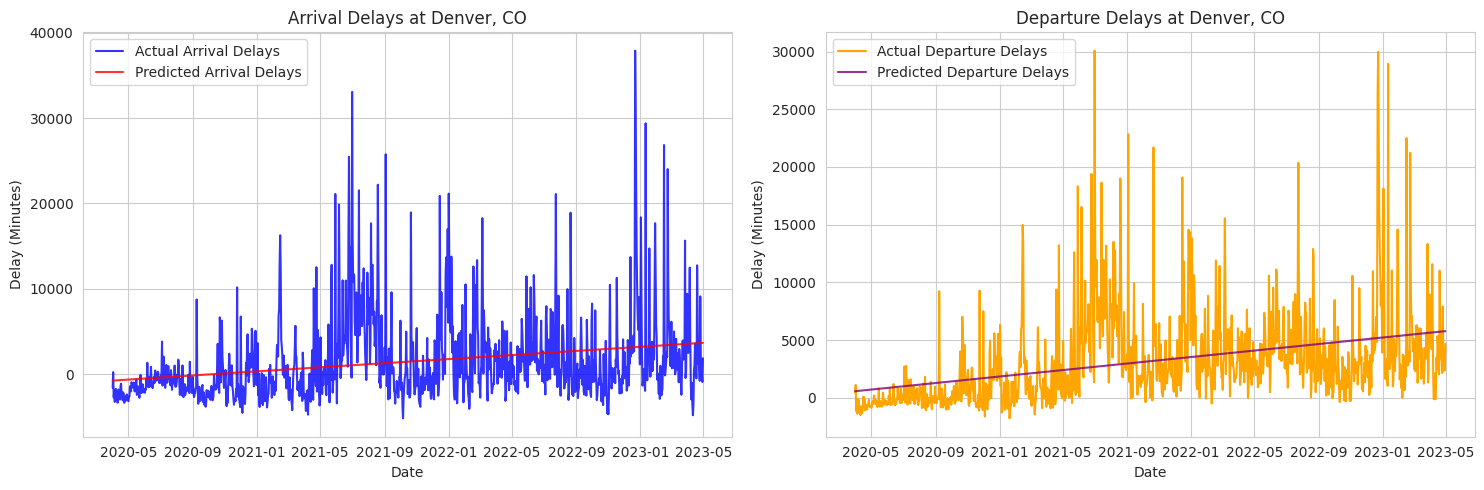

<Figure size 640x480 with 0 Axes>

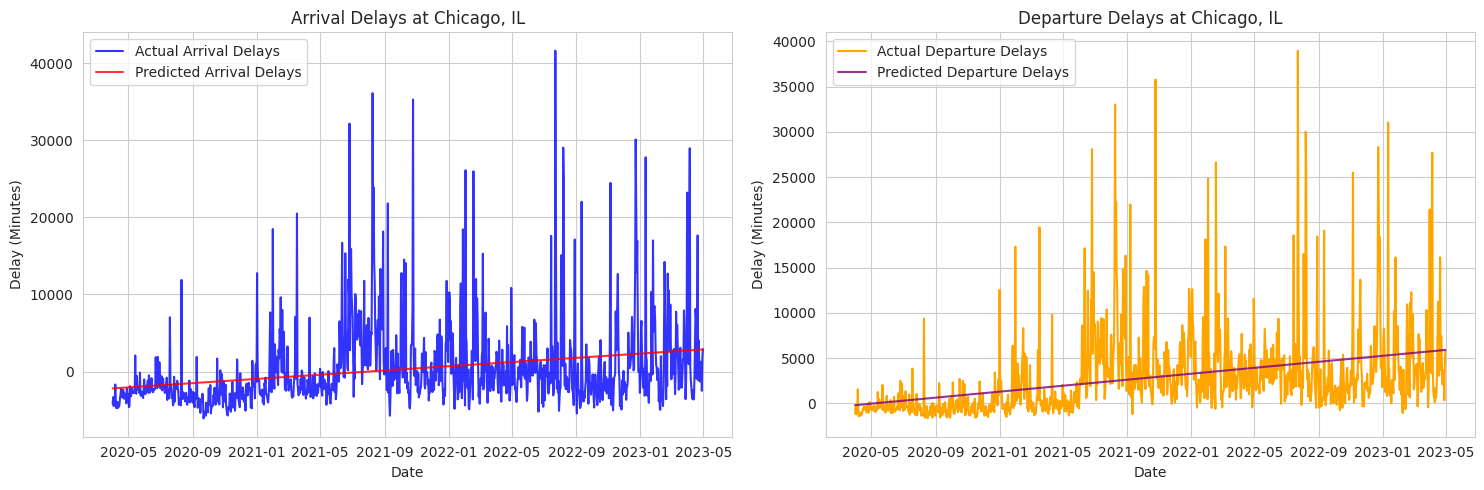

<Figure size 640x480 with 0 Axes>

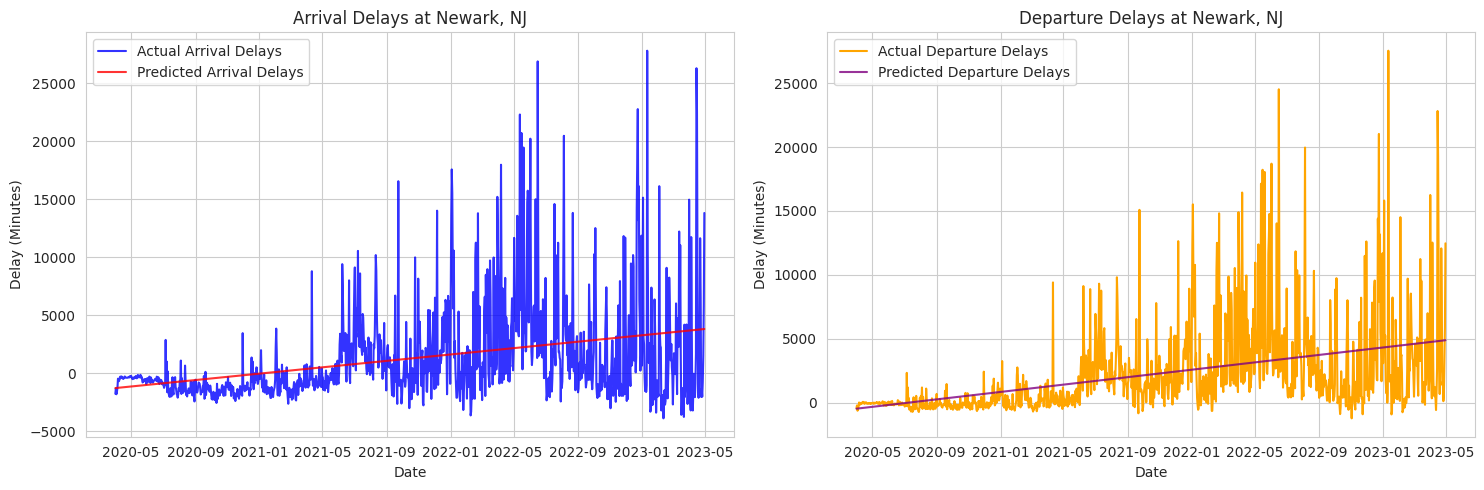

<Figure size 640x480 with 0 Axes>

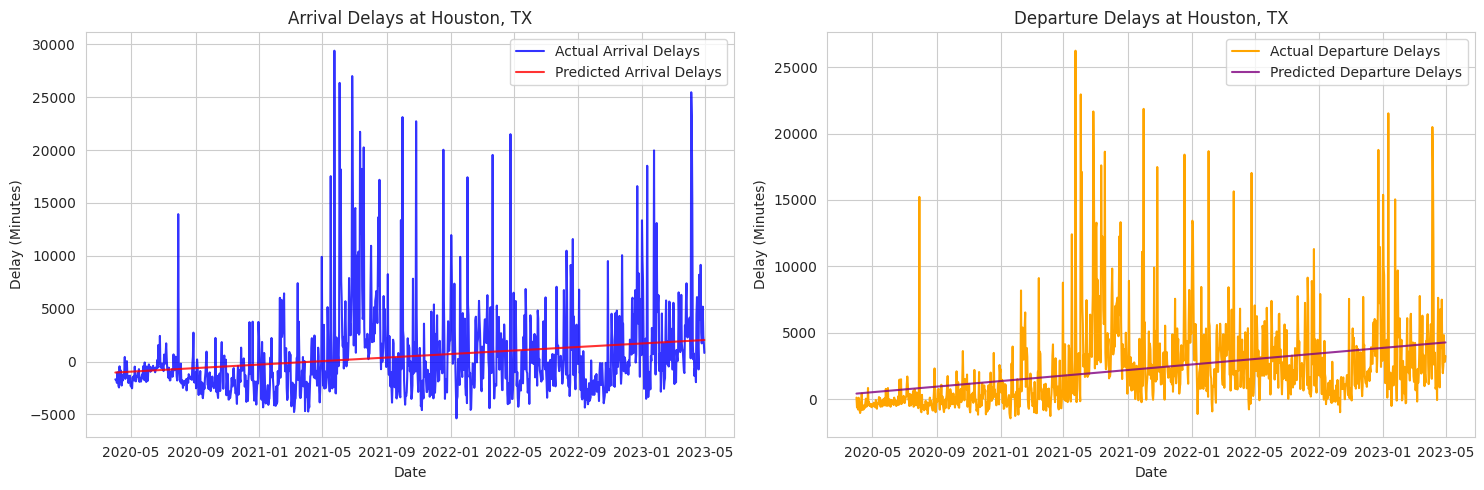

<Figure size 640x480 with 0 Axes>

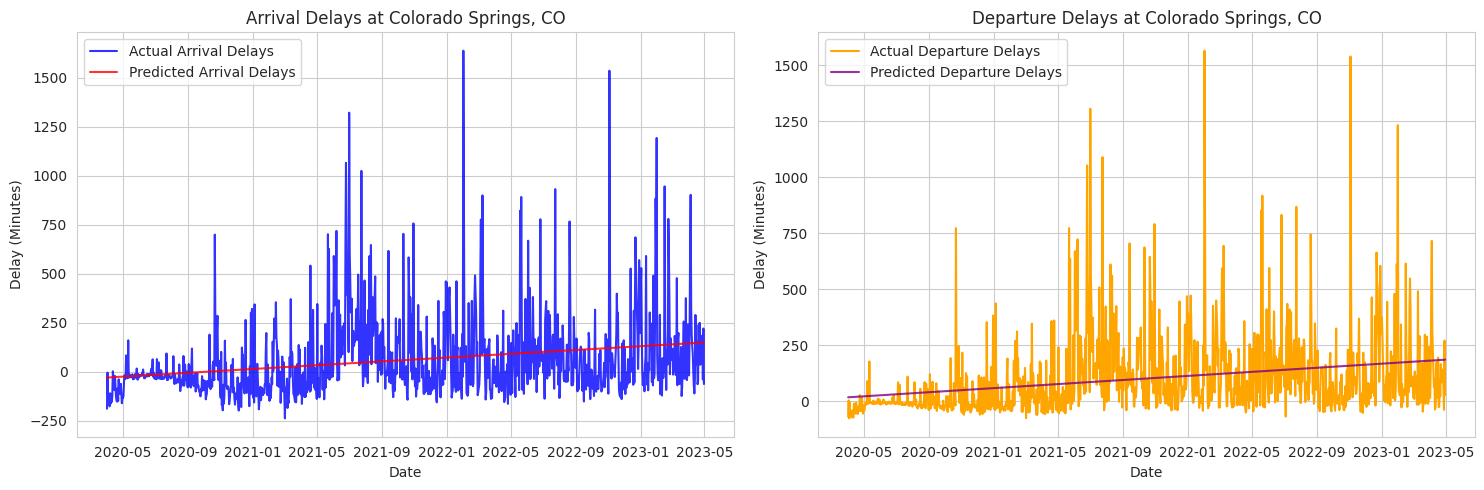

<Figure size 640x480 with 0 Axes>

In [196]:
# Train separate Linear Regression models for arrival and departure delays
for airport in top_airport_names:
    airport_data = delays_by_airport_date[delays_by_airport_date['destination'] == airport]

    X = airport_data[['date_index']]

    # Train for arrival delays
    y_arrival = airport_data['arr_delay']
    model_arr = LinearRegression()
    model_arr.fit(X, y_arrival)

    # Train for departure delays
    y_departure = airport_data['dep_delay']
    model_dep = LinearRegression()
    model_dep.fit(X, y_departure)

    models[airport]['arrival'] = model_arr
    models[airport]['departure'] = model_dep

# Plot using subplots for each airport
plt.ion()  # Turn on interactive mode

for airport in top_airport_names:
    airport_data = delays_by_airport_date[delays_by_airport_date['destination'] == airport]
    X = airport_data[['date_index']]

    y_actual_arr = airport_data['arr_delay']
    y_actual_dep = airport_data['dep_delay']

    y_pred_arr = models[airport]['arrival'].predict(X)
    y_pred_dep = models[airport]['departure'].predict(X)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

    # Arrival Delays
    axes[0].plot(airport_data['date'], y_actual_arr, label="Actual Arrival Delays", color='blue',alpha=0.8)
    axes[0].plot(airport_data['date'], y_pred_arr, label="Predicted Arrival Delays", color='red', linestyle='-', alpha=0.8)
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Delay (Minutes)")
    axes[0].set_title(f"Arrival Delays at {airport}")
    axes[0].legend()
    axes[0].grid(True)

    # Departure Delays
    axes[1].plot(airport_data['date'], y_actual_dep, label="Actual Departure Delays", color='orange')
    axes[1].plot(airport_data['date'], y_pred_dep, label="Predicted Departure Delays", color='purple', linestyle='-', alpha=0.8)
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Delay (Minutes)")
    axes[1].set_title(f"Departure Delays at {airport}")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.draw()
    plt.pause(1)  # Pause for smooth visualization
    plt.clf()  # Clear figure for the next airport

plt.ioff()  # Turn off interactive mode



## Polynomial Regression of arrival and departure delays for top 5 Airports of United Airlines

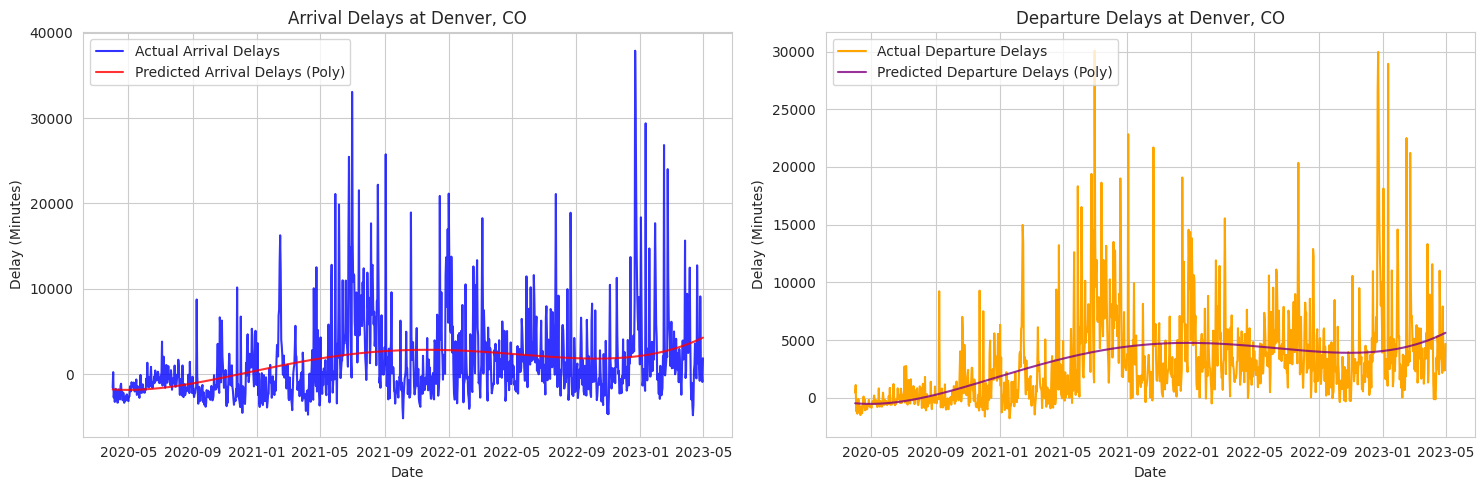

<Figure size 640x480 with 0 Axes>

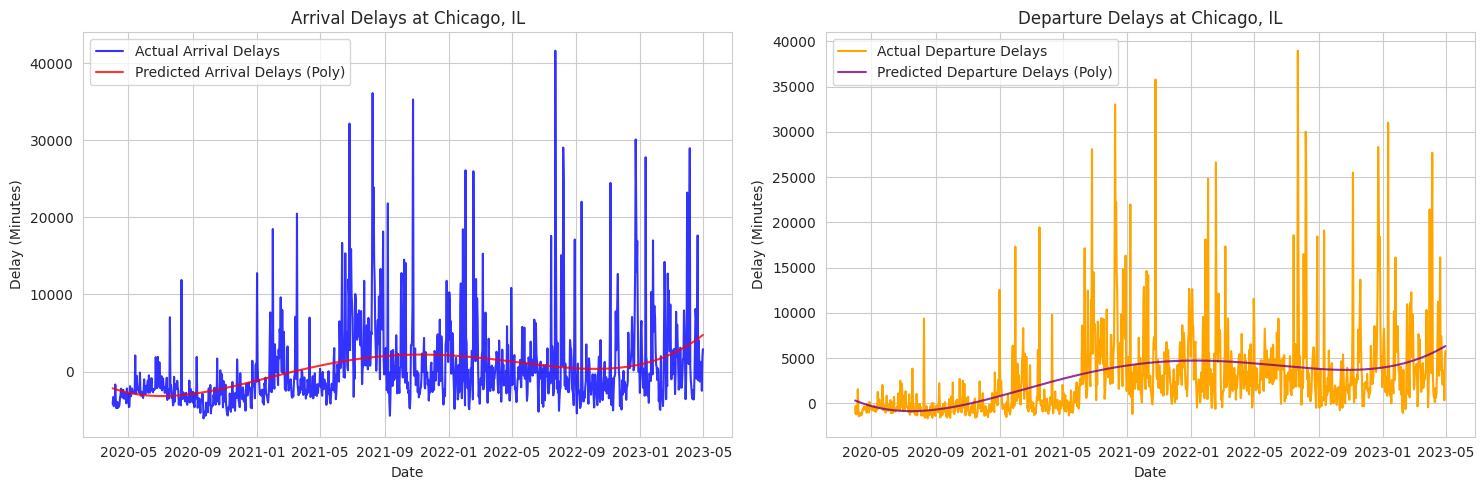

<Figure size 640x480 with 0 Axes>

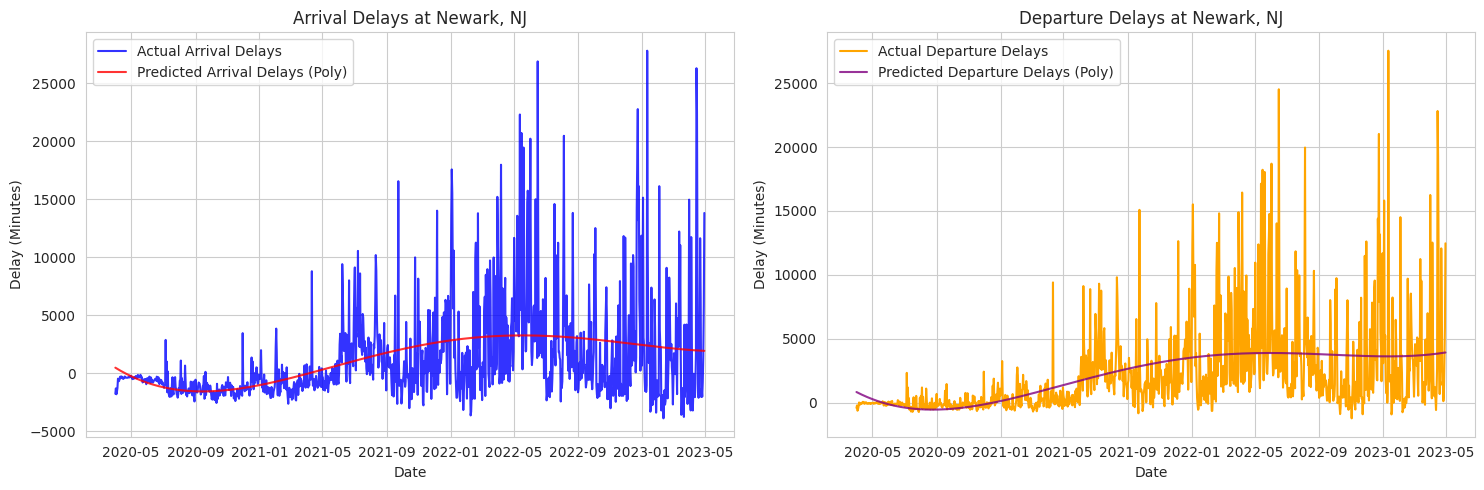

<Figure size 640x480 with 0 Axes>

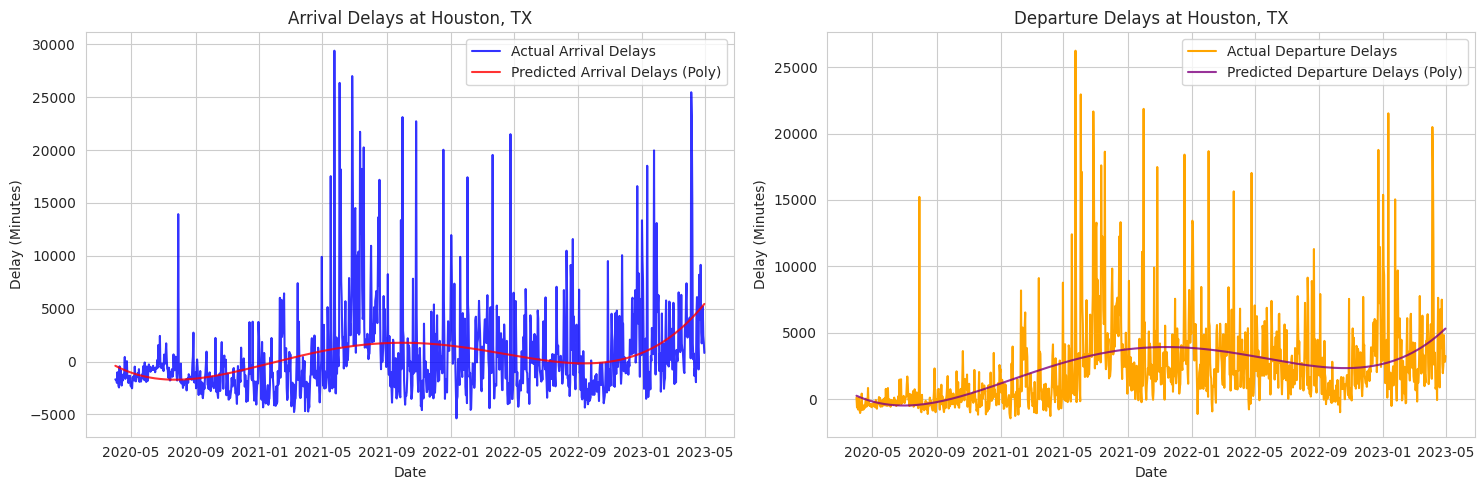

<Figure size 640x480 with 0 Axes>

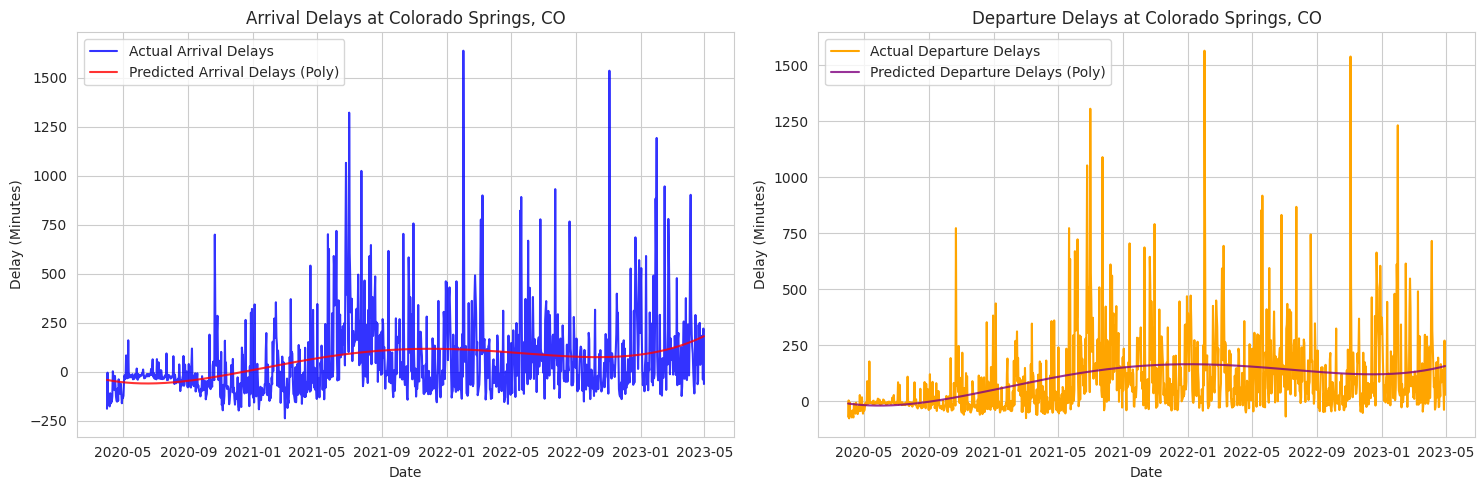

<Figure size 640x480 with 0 Axes>

In [197]:
degree = 4 # Polynomial degree

# Train Polynomial Regression models for arrival and departure delays
for airport in top_airport_names:
    airport_data = delays_by_airport_date[delays_by_airport_date['destination'] == airport]

    X = airport_data[['date_index']].values

    # Transform features to polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    # Train for arrival delays
    y_arrival = airport_data['arr_delay'].values
    model_arr = LinearRegression()
    model_arr.fit(X_poly, y_arrival)

    # Train for departure delays
    y_departure = airport_data['dep_delay'].values
    model_dep = LinearRegression()
    model_dep.fit(X_poly, y_departure)

    models[airport]['arrival'] = (model_arr, poly)
    models[airport]['departure'] = (model_dep, poly)

# Plot using subplots for each airport
plt.ion()  # Turn on interactive mode

for airport in top_airport_names:
    airport_data = delays_by_airport_date[delays_by_airport_date['destination'] == airport]
    X = airport_data[['date_index']].values

    # Transform features
    X_poly = models[airport]['arrival'][1].transform(X)

    # Get actual delays
    y_actual_arr = airport_data['arr_delay']
    y_actual_dep = airport_data['dep_delay']

    # Predict delays using polynomial regression
    y_pred_arr = models[airport]['arrival'][0].predict(X_poly)
    y_pred_dep = models[airport]['departure'][0].predict(X_poly)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

    # Arrival Delays
    axes[0].plot(airport_data['date'], y_actual_arr, label="Actual Arrival Delays", color='blue', alpha=0.8)
    axes[0].plot(airport_data['date'], y_pred_arr, label="Predicted Arrival Delays (Poly)", color='red', linestyle='-', alpha=0.8)
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Delay (Minutes)")
    axes[0].set_title(f"Arrival Delays at {airport}")
    axes[0].legend()
    axes[0].grid(True)

    # Departure Delays
    axes[1].plot(airport_data['date'], y_actual_dep, label="Actual Departure Delays", color='orange')
    axes[1].plot(airport_data['date'], y_pred_dep, label="Predicted Departure Delays (Poly)", color='purple', linestyle='-', alpha=0.8)
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Delay (Minutes)")
    axes[1].set_title(f"Departure Delays at {airport}")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.draw()
    plt.pause(1)  # Pause for smooth visualization
    plt.clf()  # Clear figure for the next airport

plt.ioff()  # Turn off interactive mode


## Scatter Plot for Hypothesis testing variables

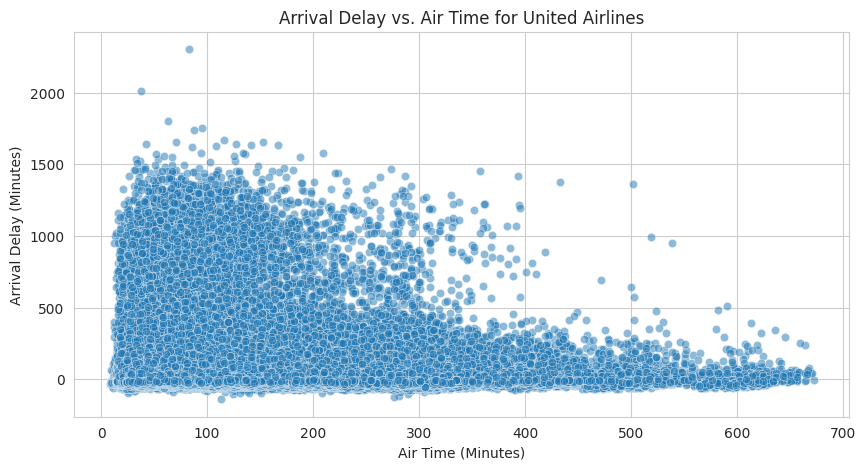

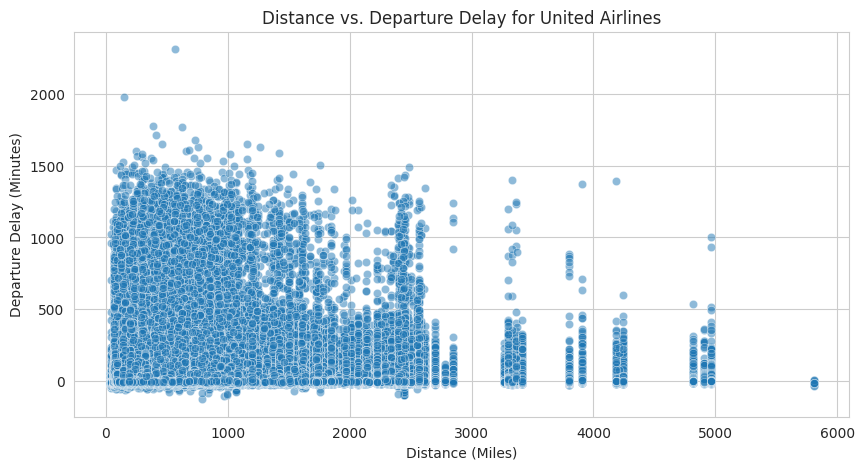

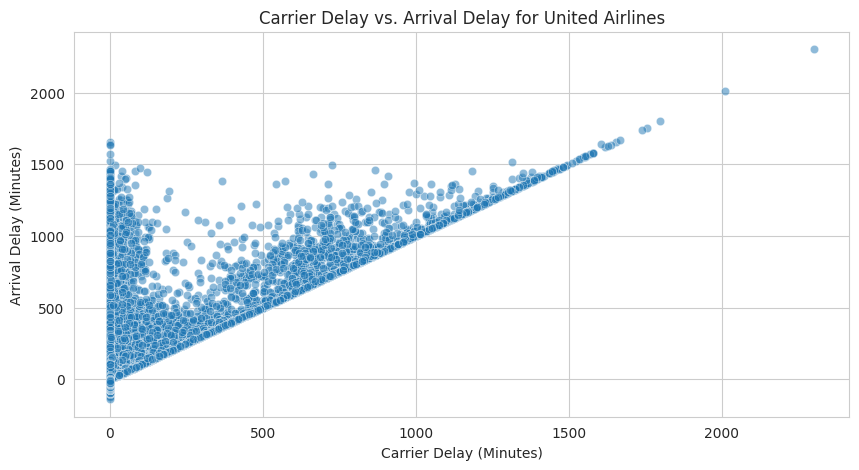

In [198]:
airline_code = 'United Airlines'  # Replace with the desired airline code
df = df1[df1['airline'] == airline_code]

# Hypothesis 1: Arrival Delay vs. Air Time
plt.figure(figsize=(10, 5))
sns.scatterplot(x='air_time', y='arr_delay', data=df, alpha=0.5)
plt.title(f'Arrival Delay vs. Air Time for {airline_code}')
plt.xlabel('Air Time (Minutes)')
plt.ylabel('Arrival Delay (Minutes)')
plt.show()

# Hypothesis 2: Distance vs. Departure Delay
plt.figure(figsize=(10, 5))
sns.scatterplot(x='dist', y='dep_delay', data=df, alpha=0.5)
plt.title(f'Distance vs. Departure Delay for {airline_code}')
plt.xlabel('Distance (Miles)')
plt.ylabel('Departure Delay (Minutes)')
plt.show()

# Hypothesis 3: Carrier Delay vs. Arrival Delay
plt.figure(figsize=(10, 5))
sns.scatterplot(x='carrier_delay', y='arr_delay', data=df, alpha=0.5)
plt.title(f'Carrier Delay vs. Arrival Delay for {airline_code}')
plt.xlabel('Carrier Delay (Minutes)')
plt.ylabel('Arrival Delay (Minutes)')
plt.show()


In [199]:
# Hypothesis 1: Arrival Delay vs. Air Time
corr_airtime_arrdelay, p_airtime_arrdelay = stats.pearsonr(df['air_time'].dropna(), df['arr_delay'].dropna())
print()
print(f"Hypothesis 1: Correlation between Air Time and Arrival Delay for {airline_code}: {corr_airtime_arrdelay:.3f}, p-value: {p_airtime_arrdelay:.3f}")
print()
# Hypothesis 2: Distance vs. Departure Delay
corr_dist_depdelay, p_dist_depdelay = stats.pearsonr(df['dist'].dropna(), df['dep_delay'].dropna())
print()
print(f"Hypothesis 2: Correlation between Distance and Departure Delay for {airline_code}: {corr_dist_depdelay:.3f}, p-value: {p_dist_depdelay:.3f}")
print()
# Hypothesis 3: Carrier Delay vs. Arrival Delay
corr_carrier_arrdelay, p_carrier_arrdelay = stats.pearsonr(df['carrier_delay'].dropna(), df['arr_delay'].dropna())
print()
print(f"Hypothesis 3: Correlation between Carrier Delay and Arrival Delay for {airline_code}: {corr_carrier_arrdelay:.3f}, p-value: {p_carrier_arrdelay:.3f}")


<ipython-input-199-217563aa75bb>:2: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  corr_airtime_arrdelay, p_airtime_arrdelay = stats.pearsonr(df['air_time'].dropna(), df['arr_delay'].dropna())
<ipython-input-199-217563aa75bb>:7: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  corr_dist_depdelay, p_dist_depdelay = stats.pearsonr(df['dist'].dropna(), df['dep_delay'].dropna())



Hypothesis 1: Correlation between Air Time and Arrival Delay for United Airlines: -0.010, p-value: 0.000


Hypothesis 2: Correlation between Distance and Departure Delay for United Airlines: 0.001, p-value: 0.129


Hypothesis 3: Correlation between Carrier Delay and Arrival Delay for United Airlines: 0.694, p-value: 0.000


<ipython-input-199-217563aa75bb>:12: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  corr_carrier_arrdelay, p_carrier_arrdelay = stats.pearsonr(df['carrier_delay'].dropna(), df['arr_delay'].dropna())


The correlation coefficient (r-value) indicates the strength and direction of the relationship (ranges from -1 to 1).
- Positive value: As one variable increases, the other tends to increase.-
- Negative value: As one variable increases, the other tends to decrease.
- Close to 0: No significant relationship.
The p-value helps determine statistical significance:
- p < 0.05: Statistically significant correlation (reject null hypothesis).
- p >= 0.05: No significant correlation (fail to reject null hypothesis).



### Observations and analysis
# **Hypothesis Testing Results for United Airlines**

## **Hypothesis 2: Air Time vs. Arrival Delay**
- **Correlation:** -0.010 (very weak negative correlation)  
- **p-value:** 0.000 (statistically significant)  
- **Interpretation:**  
  - Even though the correlation is statistically significant (*p* < 0.05), the correlation coefficient is extremely close to 0.  
  - This means that in practice, there is no meaningful relationship between air time and arrival delay for United Airlines.  



## **Hypothesis 3: Distance vs. Departure Delay**
- **Correlation:** 0.001 (almost no correlation)  
- **p-value:** 0.129 (not statistically significant)  
- **Interpretation:**  
  - Since the *p*-value is greater than 0.05, we fail to reject the null hypothesis.  
  - This suggests that there is no significant relationship between flight distance and departure delay for United Airlines.  



## **Hypothesis 4: Carrier Delay vs. Arrival Delay**
- **Correlation:** 0.694 (strong positive correlation)  
- **p-value:** 0.000 (statistically significant)  
- **Interpretation:**  
  - There is a **strong positive correlation** between carrier delay and arrival delay.  
  - This means that when carrier delays increase, arrival delays also tend to increase significantly.  
  - Since the *p*-value is very low, this relationship is statistically significant.  



## **Final Conclusion**
- **Hypothesis 2 & 3:** We fail to reject the null hypothesis (**no meaningful relationship**).  
- **Hypothesis 4:** We reject the null hypothesis (**strong positive relationship**).  


In [200]:
# Binning Arrival Delay (arr_delay)
bins_arr_delay = [-np.inf, 15, 30, 45, 60, np.inf]  # Define the bins for arrival delay
labels_arr_delay = ['0-15', '16-30', '31-45', '46-60', '60+']
df.loc[:, 'arr_delay_binned'] = pd.cut(df['arr_delay'], bins=bins_arr_delay, labels=labels_arr_delay)

# Binning Air Time (air_time)
bins_air_time = [-np.inf, 30, 60, 120, 180, np.inf]  # Define the bins for air time
labels_air_time = ['0-30', '31-60', '61-120', '121-180', '180+']
df.loc[:, 'air_time_binned'] = pd.cut(df['air_time'], bins=bins_air_time, labels=labels_air_time)

<ipython-input-200-016f0aaa3372>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'arr_delay_binned'] = pd.cut(df['arr_delay'], bins=bins_arr_delay, labels=labels_arr_delay)
<ipython-input-200-016f0aaa3372>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'air_time_binned'] = pd.cut(df['air_time'], bins=bins_air_time, labels=labels_air_time)


In [201]:
# Hypothesis 1: Arrival Delay and Air Time Relationship
contingency_table_1 = pd.crosstab(df['arr_delay_binned'], df['air_time_binned'])
chi2_stat_1, p_value_1, dof_1, expected_1 = chi2_contingency(contingency_table_1)
print("\nHypothesis 1: Correlation between Arrival Delay and Air Time")
print("Chi-square Statistic:", chi2_stat_1)
print("P-value:", p_value_1)
if p_value_1 < 0.05:
    print("Reject Null Hypothesis: There is a significant correlation between Arrival Delay and Air Time.")
else:
    print("Accept Null Hypothesis: There is no significant correlation between Arrival Delay and Air Time.")

# Hypothesis 2: Effect of Distance on Delay
contingency_table_2 = pd.crosstab(df['dist'], df['dep_delay'])
chi2_stat_2, p_value_2, dof_2, expected_2 = chi2_contingency(contingency_table_2)
print("\nHypothesis 2: Correlation between Distance and Departure Delay")
print("Chi-square Statistic:", chi2_stat_2)
print("P-value:", p_value_2)
if p_value_2 < 0.05:
    print("Reject Null Hypothesis: Distance significantly impacts Departure Delay.")
else:
    print("Accept Null Hypothesis: Distance does not significantly impact Departure Delay.")

# Hypothesis 3: Impact of Carrier Delays on Arrival Delays
contingency_table_3 = pd.crosstab(df['carrier_delay'], df['arr_delay'])
chi2_stat_3, p_value_3, dof_3, expected_3 = chi2_contingency(contingency_table_3)
print("\nHypothesis 3: Correlation between Carrier Delay and Arrival Delay")
print("Chi-square Statistic:", chi2_stat_3)
print("P-value:", p_value_3)
if p_value_3 < 0.05:
    print("Reject Null Hypothesis: Carrier delays significantly impact Arrival Delay.")
else:
    print("Accept Null Hypothesis: Carrier delays do not significantly impact Arrival Delay.")



Hypothesis 1: Correlation between Arrival Delay and Air Time
Chi-square Statistic: 3964.171396132437
P-value: 0.0
Reject Null Hypothesis: There is a significant correlation between Arrival Delay and Air Time.

Hypothesis 2: Correlation between Distance and Departure Delay
Chi-square Statistic: 1822189.199576479
P-value: 0.0
Reject Null Hypothesis: Distance significantly impacts Departure Delay.

Hypothesis 3: Correlation between Carrier Delay and Arrival Delay
Chi-square Statistic: 1336517743.2692347
P-value: 0.0
Reject Null Hypothesis: Carrier delays significantly impact Arrival Delay.


The p-value of 0.0 that you're seeing in the output is  due to the Chi-square test returning a very small value that is so close to zero that it's rounded down. This happens when the Chi-square statistic is large, indicating a very strong relationship between the variables, and the test concludes that the null hypothesis can be rejected with high confidence.


- **Large Sample Size**: When we have a large number of observations, even small differences between the observed and expected frequencies can lead to a very large Chi-square statistic, and consequently, a p-value close to zero. In this case, this could be due to a large number of observations in the dataset, which amplifies the significance of the differences.
  
- **Large Chi-square Statistic**: When the Chi-square statistic is very large (as in  results), the p-value is often so small that it's effectively reported as `0.0` (or a value that's too small to be represented with precision).

- **Data Distributions**: If the data has very distinct categories, with little overlap between the groups you're testing (for example, if most observations fall into distinct bins), the Chi-square test may also return a very low p-value, indicating a very strong association.

In [202]:
# Function for fitting polynomial regression
def polynomial_reg(X, y, degree):
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X)
    model = LinearRegression()
    model.fit(X_poly, y)
    return model

# Function for fitting linear regression
def linear_reg(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model

x_val = np.arange(len(delays_by_date)).reshape(-1, 1)
y_val1 = delays_by_date['arr_delay']
y_val2 = delays_by_date['dep_delay']

In [203]:
# Function for calculating RMSE (Root Mean Squared Error)
def rmse_cal(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Function to calculate confidence intervals
def calc_confidence_intervals(model, X, y, confidence=0.95):
    predictions = model.predict(X)
    residuals = y - predictions
    std_err = np.std(residuals)
    ci_upper = predictions + std_err * 1.96
    ci_lower = predictions - std_err * 1.96
    return np.column_stack((ci_lower, ci_upper))

In [204]:
# Function to fit a polynomial regression model
def polynomial_regression(X, y, degree=3):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    model.fit(X_poly, y)
    return model, poly

# Function to plot polynomial regression results
def plot_poly_reg_results_subplots(x, y, y_pred, title, confidence_interval=None, forecast_dates=None, forecast_values=None, forecast_ci=None, subplot_title=None):
    plt.plot(x, y, label='Actual', color='blue')
    plt.plot(x, y_pred, label='Polynomial Trend Line', color='red')
    if confidence_interval is not None:
        plt.fill_between(x.flatten(), confidence_interval[:, 0], confidence_interval[:, 1], alpha=0.3, color='yellow', label='95% Confidence Interval')
    if forecast_dates is not None and forecast_values is not None:
        plt.plot(forecast_dates, forecast_values, label='Forecasted Values', color='green')
    plt.xlabel('Number of Days')
    plt.ylabel(title)
    plt.title(f'{subplot_title} - {title} Trend, Prediction, and Confidence Intervals')
    plt.legend()


## UA Arrival and Departure delays (Trend, Prediction, and Confidence Intervals)-Linear regression

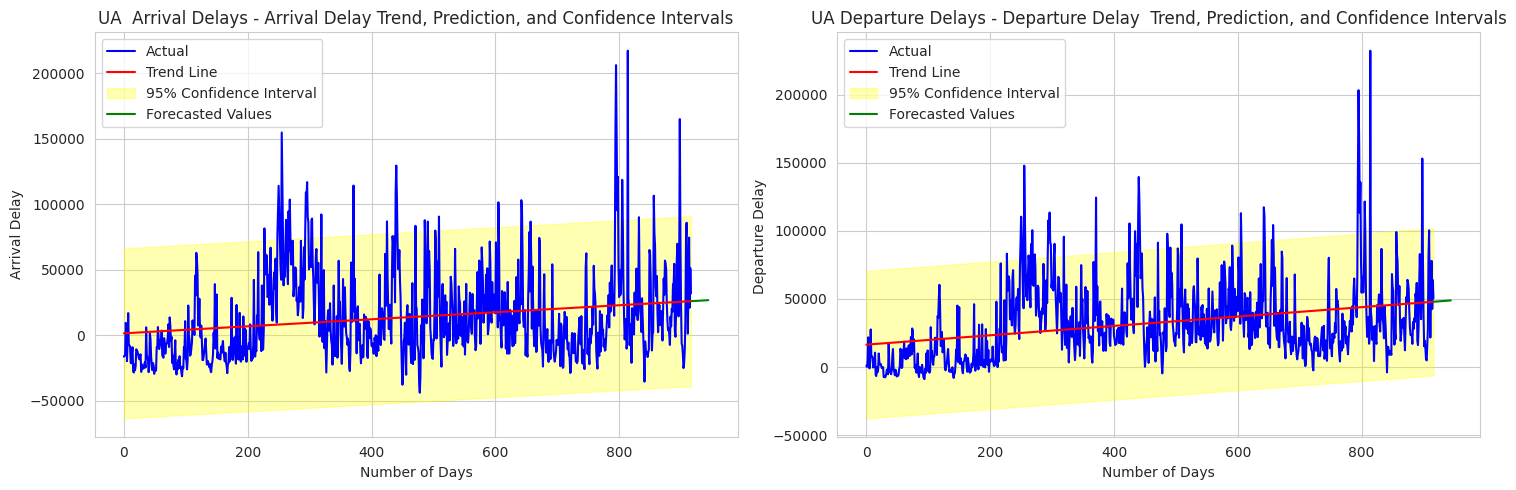

In [205]:
# Fitting linear regression models for arrival and departure delays
lm_arr_delay = linear_reg(x_val, y_val1)
lm_dep_delay = linear_reg(x_val, y_val2)

# Predicting with the models
y_pred_lm_arr = lm_arr_delay.predict(x_val)
y_pred_lm_dep = lm_dep_delay.predict(x_val)

# Calculating RMSE for arrival and departure delays
rmse_lm_arr = rmse_cal(y_val1, y_pred_lm_arr)
rmse_lm_dep = rmse_cal(y_val2, y_pred_lm_dep)

# Calculating confidence intervals
confidence_interval_arr = calc_confidence_intervals(lm_arr_delay, x_val, y_val1)
confidence_interval_dep = calc_confidence_intervals(lm_dep_delay, x_val, y_val2)

# Forecasting 7 days ahead
forecast_days = 28  # Forecasting 7 days ahead

# Generate forecast dates (next 7 days)
forecast_dates = x_val[-1] + np.arange(1, forecast_days + 1).reshape(-1, 1)

# Make predictions for the forecast dates for both arrival and departure delays
forecast_values_arr = lm_arr_delay.predict(forecast_dates)
forecast_values_dep = lm_dep_delay.predict(forecast_dates)

# Calculate confidence intervals for forecast values
confidence_interval_forecast_arr = calc_confidence_intervals(lm_arr_delay, forecast_dates, forecast_values_arr)
confidence_interval_forecast_dep = calc_confidence_intervals(lm_dep_delay, forecast_dates, forecast_values_dep)

# Function to plot actual vs. predicted values
def plot_reg_results_subplots(x, y, y_pred, title, confidence_interval=None, forecast_dates=None, forecast_values=None, forecast_ci=None, subplot_title=None, subplot_color=None):
    plt.plot(x, y, label='Actual', color='blue')
    plt.plot(x, y_pred, label='Trend Line', color='red')
    if confidence_interval is not None:
        plt.fill_between(x.flatten(), confidence_interval[:, 0], confidence_interval[:, 1], alpha=0.3, color='yellow', label='95% Confidence Interval')
    if forecast_dates is not None and forecast_values is not None:
        plt.plot(forecast_dates, forecast_values, label='Forecasted Values', color='green')
    plt.xlabel('Number of Days')
    plt.ylabel(title)
    plt.title(f'{subplot_title} - {title} Trend, Prediction, and Confidence Intervals')
    plt.legend()

# Function to plot multiple regression results with subplots
def plot_reg_results_with_subplots(x_vals, y_vals, y_pred_vals, titles, confidence_intervals=None, forecast_dates=None, forecast_values=None, forecast_ci=None, subplot_titles=None):
    num_plots = len(x_vals)
    num_rows = (num_plots + 1) // 2
    num_cols = 2 if num_plots > 1 else 1

    plt.figure(figsize=(15, 5 * num_rows))

    for i in range(num_plots):
        plt.subplot(num_rows, num_cols, i + 1)
        plot_reg_results_subplots(
            x_vals[i], y_vals[i], y_pred_vals[i], titles[i],
            confidence_intervals[i], forecast_dates[i], forecast_values[i], forecast_ci[i], subplot_titles[i]
        )

    plt.tight_layout()
    plt.show()

# Call the function to plot regression results for arrival and departure delays
plot_reg_results_with_subplots(
    [x_val, x_val],
    [y_val1, y_val2],
    [y_pred_lm_arr, y_pred_lm_dep],
    ['Arrival Delay', 'Departure Delay '],
    [confidence_interval_arr, confidence_interval_dep],
    [forecast_dates, forecast_dates],  # Forecast dates for arrival and departure delays
    [forecast_values_arr, forecast_values_dep],  # Forecasted values for arrival and departure delays
    [confidence_interval_forecast_arr, confidence_interval_forecast_dep],  # Forecast confidence intervals
    ['UA  Arrival Delays', 'UA Departure Delays']
)



## UA Arrival and Departure delays (Trend, Prediction, and Confidence Intervals)- Polynomial Regression

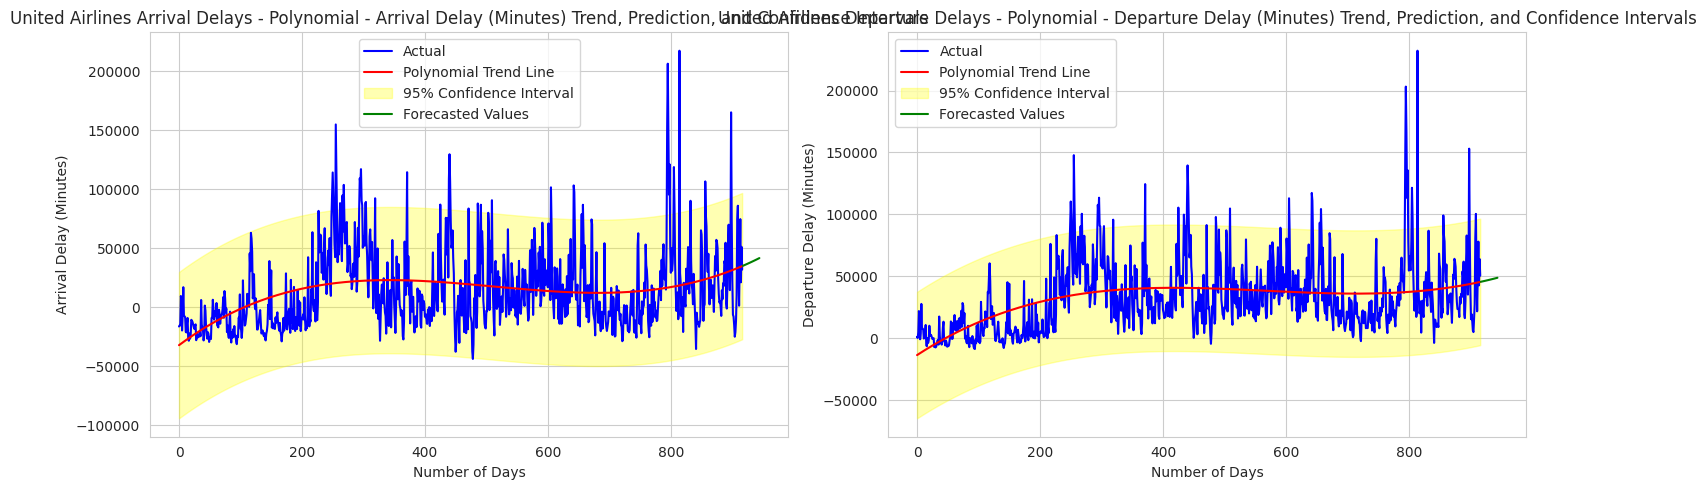

In [206]:


# Fitting polynomial regression models for arrival and departure delays
lm_arr_delay_poly, poly_arr = polynomial_regression(x_val, y_val1, degree=3)
lm_dep_delay_poly, poly_dep = polynomial_regression(x_val, y_val2, degree=3)

# Predicting with the models
y_pred_lm_arr_poly = lm_arr_delay_poly.predict(poly_arr.transform(x_val))
y_pred_lm_dep_poly = lm_dep_delay_poly.predict(poly_dep.transform(x_val))

# Calculating RMSE for arrival and departure delays
rmse_lm_arr_poly = rmse_cal(y_val1, y_pred_lm_arr_poly)
rmse_lm_dep_poly = rmse_cal(y_val2, y_pred_lm_dep_poly)

# Calculating confidence intervals
confidence_interval_arr_poly = calc_confidence_intervals(lm_arr_delay_poly, poly_arr.transform(x_val), y_val1)
confidence_interval_dep_poly = calc_confidence_intervals(lm_dep_delay_poly, poly_dep.transform(x_val), y_val2)

# Forecasting 7 days ahead
forecast_days = 28  # Forecasting 7 days ahead

# Generate forecast dates (next 7 days)
forecast_dates = x_val[-1] + np.arange(1, forecast_days + 1).reshape(-1, 1)

# Make predictions for the forecast dates for both arrival and departure delays
forecast_values_arr_poly = lm_arr_delay_poly.predict(poly_arr.transform(forecast_dates))
forecast_values_dep_poly = lm_dep_delay_poly.predict(poly_dep.transform(forecast_dates))

# Calculate confidence intervals for forecast values
confidence_interval_forecast_arr_poly = calc_confidence_intervals(lm_arr_delay_poly, poly_arr.transform(forecast_dates), forecast_values_arr_poly)
confidence_interval_forecast_dep_poly = calc_confidence_intervals(lm_dep_delay_poly, poly_dep.transform(forecast_dates), forecast_values_dep_poly)


# Function to plot multiple regression results with subplots for polynomial regression
def plot_poly_reg_results_with_subplots(x_vals, y_vals, y_pred_vals, titles, confidence_intervals=None, forecast_dates=None, forecast_values=None, forecast_ci=None, subplot_titles=None):
    num_plots = len(x_vals)
    num_rows = (num_plots + 1) // 2
    num_cols = 2 if num_plots > 1 else 1

    plt.figure(figsize=(15, 5 * num_rows))

    for i in range(num_plots):
        plt.subplot(num_rows, num_cols, i + 1)
        plot_poly_reg_results_subplots(
            x_vals[i], y_vals[i], y_pred_vals[i], titles[i],
            confidence_intervals[i], forecast_dates[i], forecast_values[i], forecast_ci[i], subplot_titles[i]
        )

    plt.tight_layout()
    plt.show()

# Call the function to plot polynomial regression results for arrival and departure delays
plot_poly_reg_results_with_subplots(
    [x_val, x_val],
    [y_val1, y_val2],
    [y_pred_lm_arr_poly, y_pred_lm_dep_poly],
    ['Arrival Delay (Minutes)', 'Departure Delay (Minutes)'],
    [confidence_interval_arr_poly, confidence_interval_dep_poly],
    [forecast_dates, forecast_dates],  # Forecast dates for arrival and departure delays
    [forecast_values_arr_poly, forecast_values_dep_poly],  # Forecasted values for arrival and departure delays
    [confidence_interval_forecast_arr_poly, confidence_interval_forecast_dep_poly],  # Forecast confidence intervals
    ['United Airlines Arrival Delays - Polynomial', 'United Airlines Departure Delays - Polynomial']
)


## UA top 5 Airport delays (Trend, Prediction, and Confidence Intervals)- Linear Regression

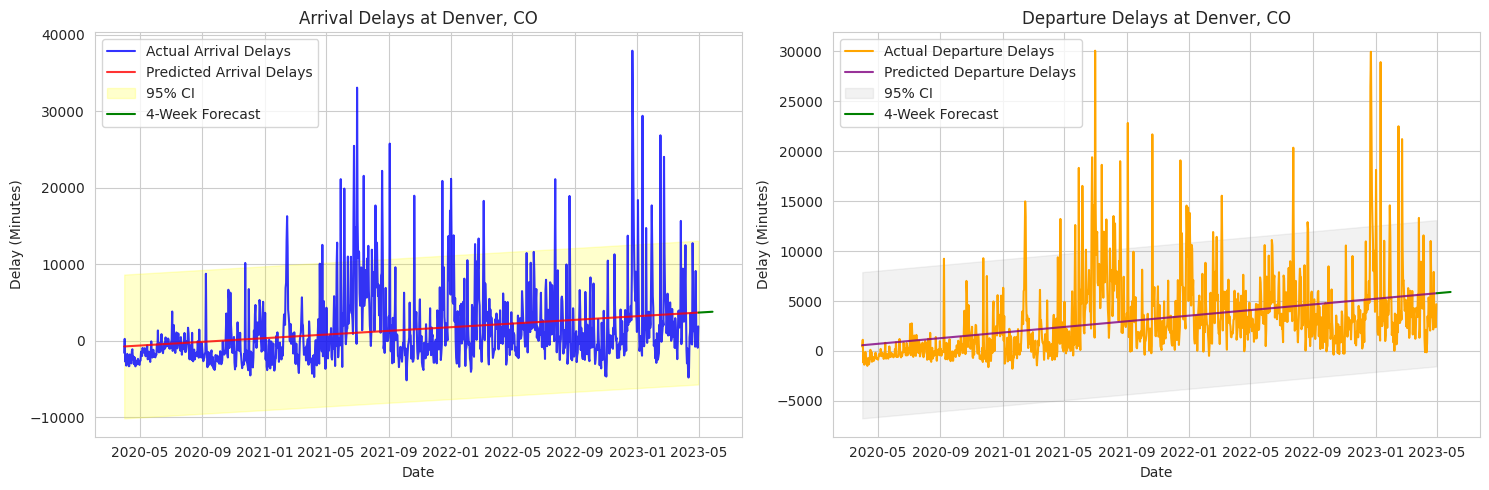

<Figure size 640x480 with 0 Axes>

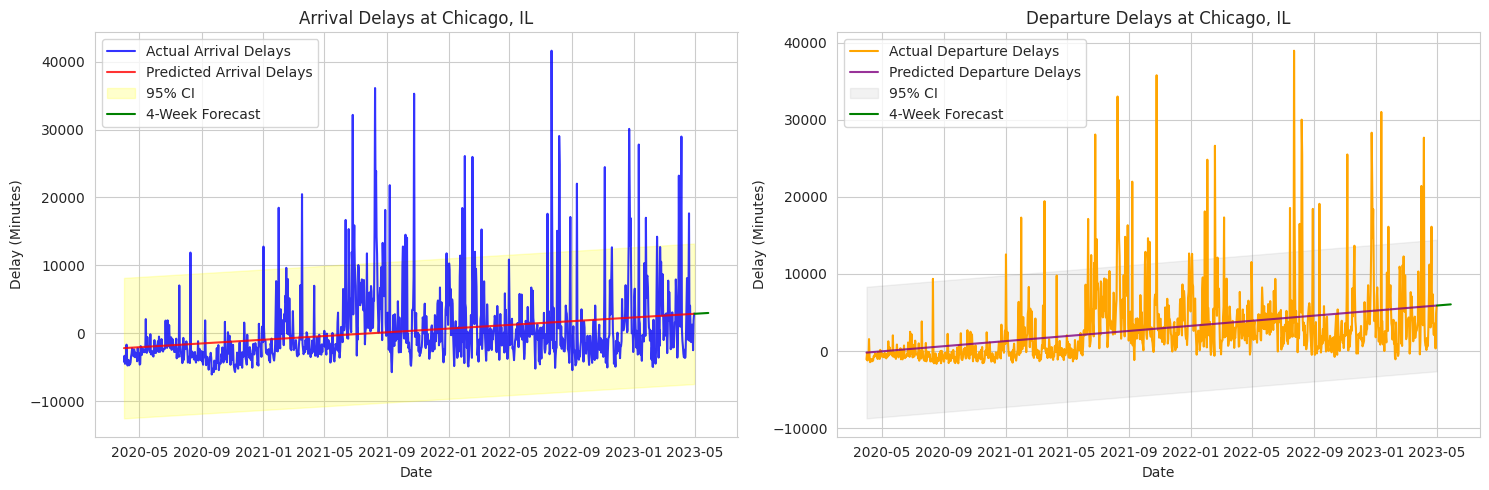

<Figure size 640x480 with 0 Axes>

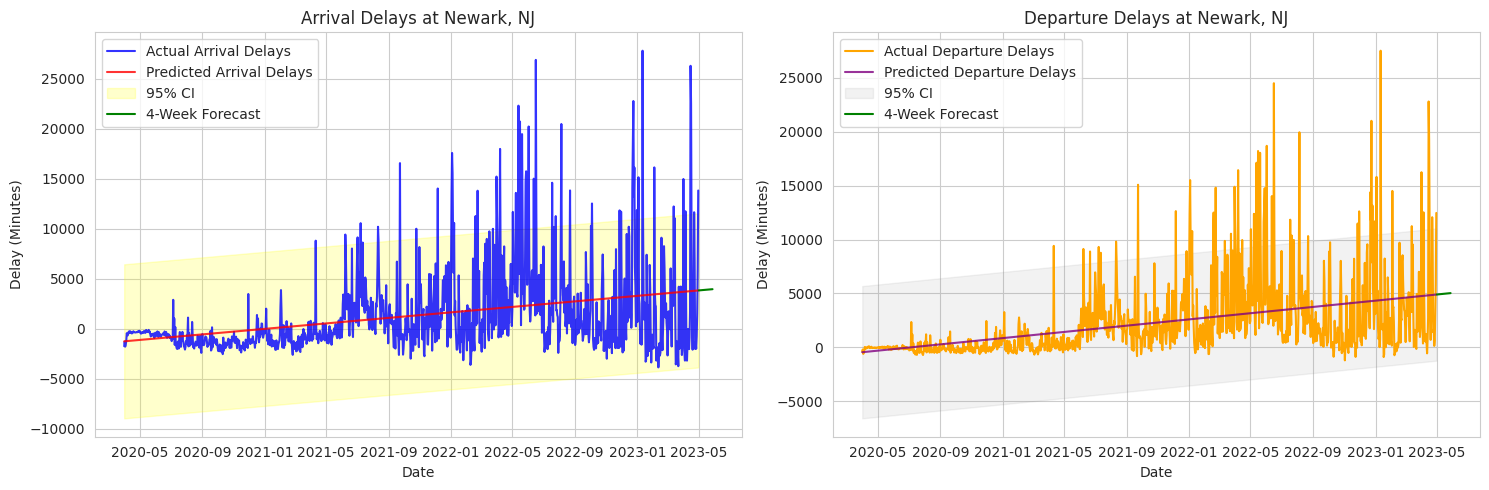

<Figure size 640x480 with 0 Axes>

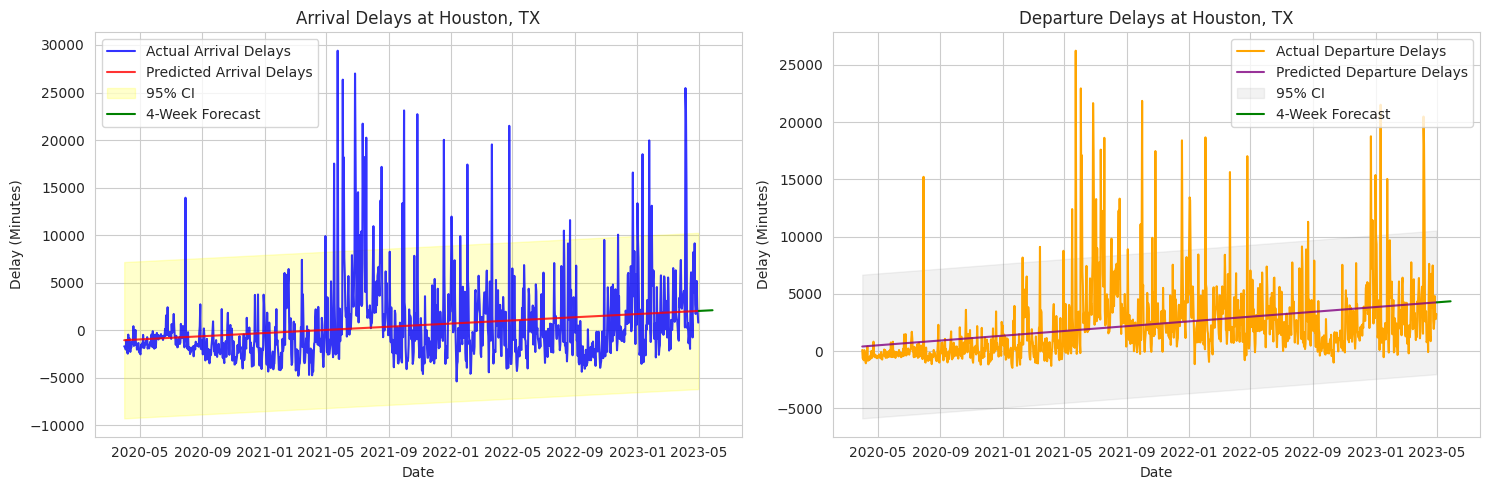

<Figure size 640x480 with 0 Axes>

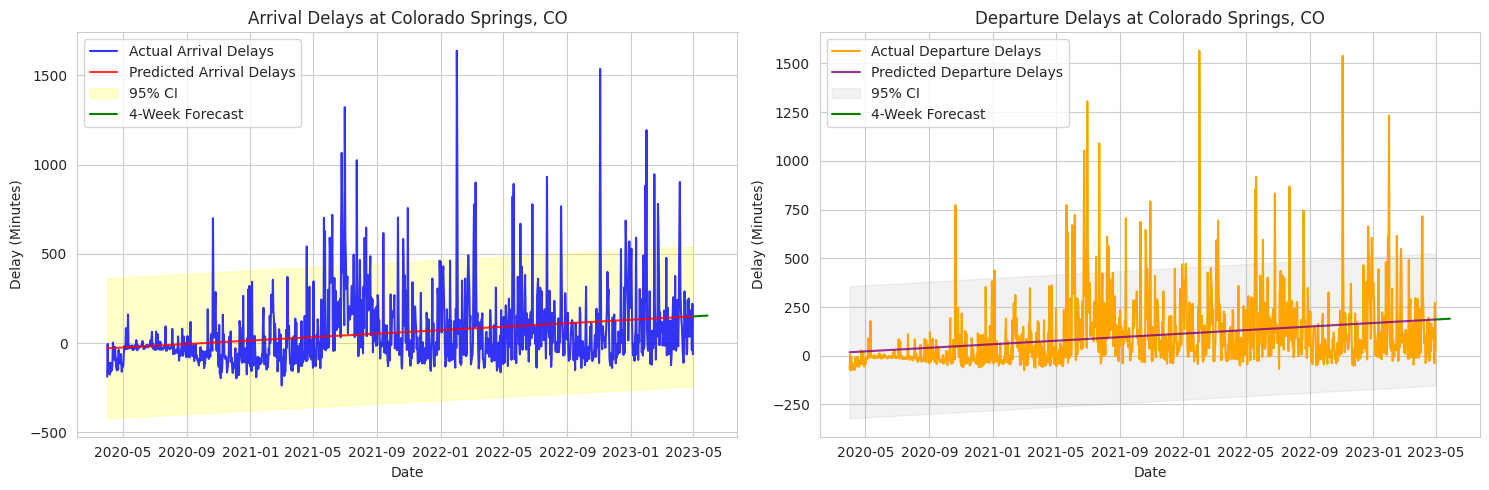

<Figure size 640x480 with 0 Axes>

In [207]:


# Train separate Linear Regression models for arrival and departure delays
models = {}

for airport in top_airport_names:
    airport_data = delays_by_airport_date[delays_by_airport_date['destination'] == airport]

    X = airport_data[['date_index']]

    # Train for arrival delays
    y_arrival = airport_data['arr_delay']
    model_arr = LinearRegression()
    model_arr.fit(X, y_arrival)

    # Compute residuals & standard deviation for confidence interval
    y_arr_pred = model_arr.predict(X)
    residuals_arr = y_arrival - y_arr_pred
    std_arr = np.std(residuals_arr)

    # Train for departure delays
    y_departure = airport_data['dep_delay']
    model_dep = LinearRegression()
    model_dep.fit(X, y_departure)

    # Compute residuals & standard deviation for confidence interval
    y_dep_pred = model_dep.predict(X)
    residuals_dep = y_departure - y_dep_pred
    std_dep = np.std(residuals_dep)

    models[airport] = {
        'arrival': model_arr,
        'departure': model_dep,
        'std_arr': std_arr,
        'std_dep': std_dep
    }

# Plot using subplots for each airport
plt.ion()  # Turn on interactive mode

for airport in top_airport_names:
    airport_data = delays_by_airport_date[delays_by_airport_date['destination'] == airport]
    X = airport_data[['date_index']]

    y_actual_arr = airport_data['arr_delay']
    y_actual_dep = airport_data['dep_delay']

    y_pred_arr = models[airport]['arrival'].predict(X)
    y_pred_dep = models[airport]['departure'].predict(X)

    std_arr = models[airport]['std_arr']
    std_dep = models[airport]['std_dep']


    # Generate 1-week forecast
    last_date_index = X.iloc[-1, 0]
    future_dates = pd.DataFrame({'date_index': np.arange(last_date_index + 1, last_date_index + 29)})  # Convert to DataFrame
    future_arr_pred = models[airport]['arrival'].predict(future_dates)
    future_dep_pred = models[airport]['departure'].predict(future_dates)


    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Arrival Delays
    axes[0].plot(airport_data['date'], y_actual_arr, label="Actual Arrival Delays", color='blue', alpha=0.8)
    axes[0].plot(airport_data['date'], y_pred_arr, label="Predicted Arrival Delays", color='red', linestyle='-', alpha=0.8)

    # Confidence Interval
    axes[0].fill_between(airport_data['date'], y_pred_arr - 1.96 * std_arr, y_pred_arr + 1.96 * std_arr, color='yellow', alpha=0.2, label="95% CI")

    # 1-week forecast
    forecast_dates = pd.date_range(start=airport_data['date'].iloc[-1], periods=29, freq='D')[1:]
    axes[0].plot(forecast_dates, future_arr_pred, label="4-Week Forecast", color='green', linestyle='-')

    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Delay (Minutes)")
    axes[0].set_title(f"Arrival Delays at {airport}")
    axes[0].legend()
    axes[0].grid(True)

    # Departure Delays
    axes[1].plot(airport_data['date'], y_actual_dep, label="Actual Departure Delays", color='orange')
    axes[1].plot(airport_data['date'], y_pred_dep, label="Predicted Departure Delays", color='purple', linestyle='-', alpha=0.8)

    # Confidence Interval
    axes[1].fill_between(airport_data['date'], y_pred_dep - 1.96 * std_dep, y_pred_dep + 1.96 * std_dep, color='grey', alpha=0.1, label="95% CI")

    # 1-week forecast
    axes[1].plot(forecast_dates, future_dep_pred, label="4-Week Forecast", color='green', linestyle='-')

    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Delay (Minutes)")
    axes[1].set_title(f"Departure Delays at {airport}")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.draw()
    plt.pause(1)
    plt.clf()

plt.ioff()


## UA top 5 Airport delays (Trend, Prediction, and Confidence Intervals)- Polynomial Regression

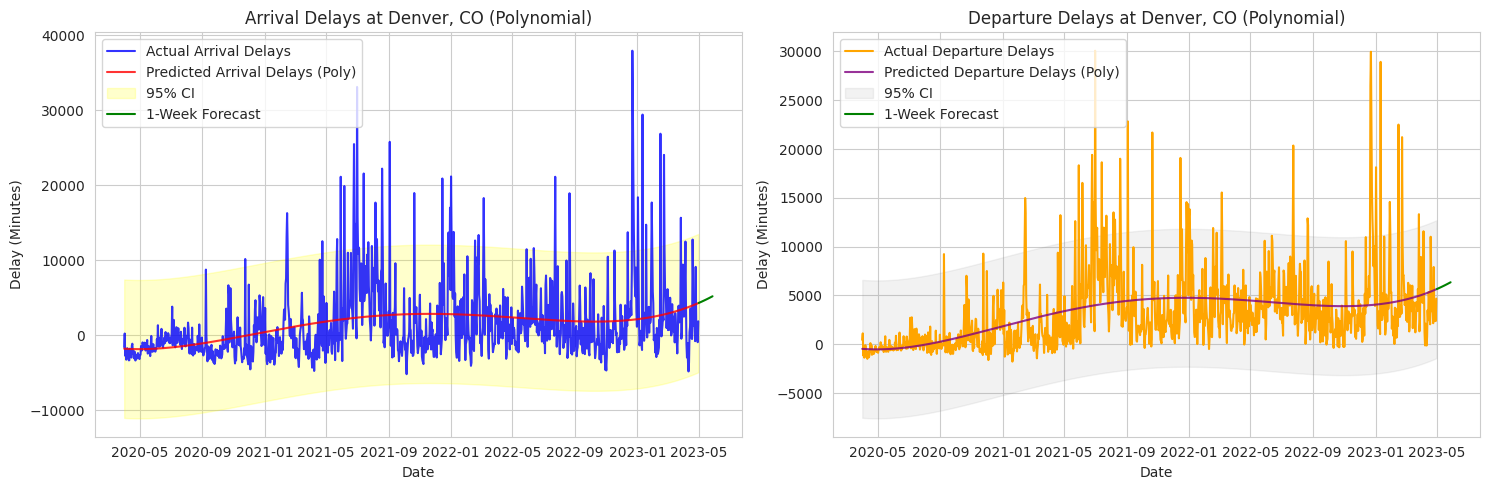

<Figure size 640x480 with 0 Axes>

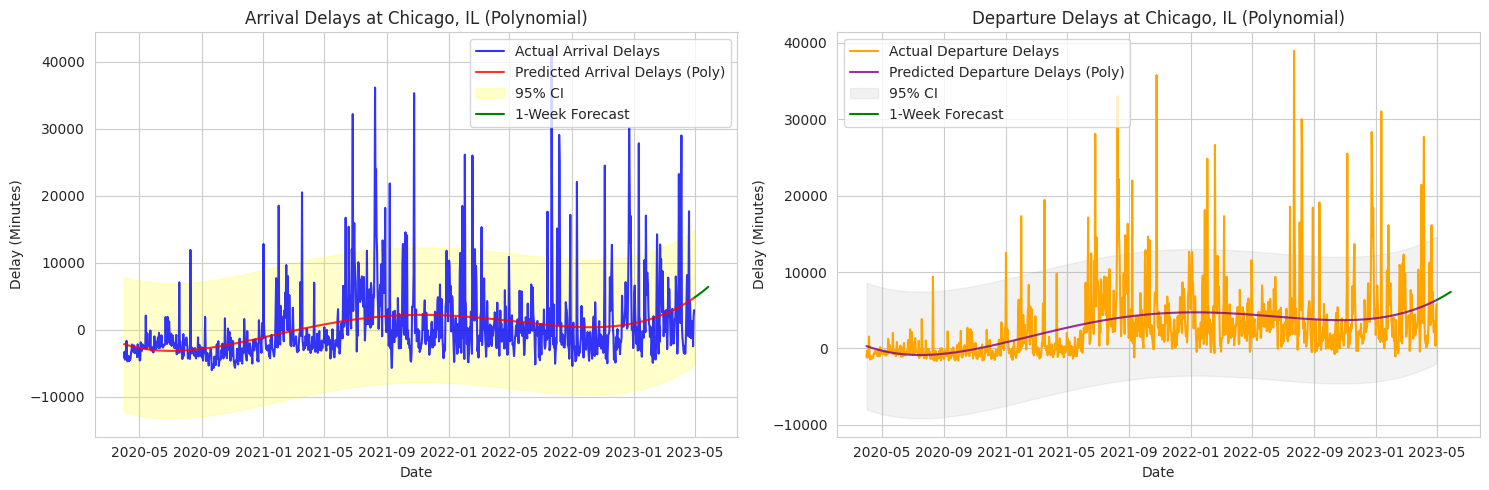

<Figure size 640x480 with 0 Axes>

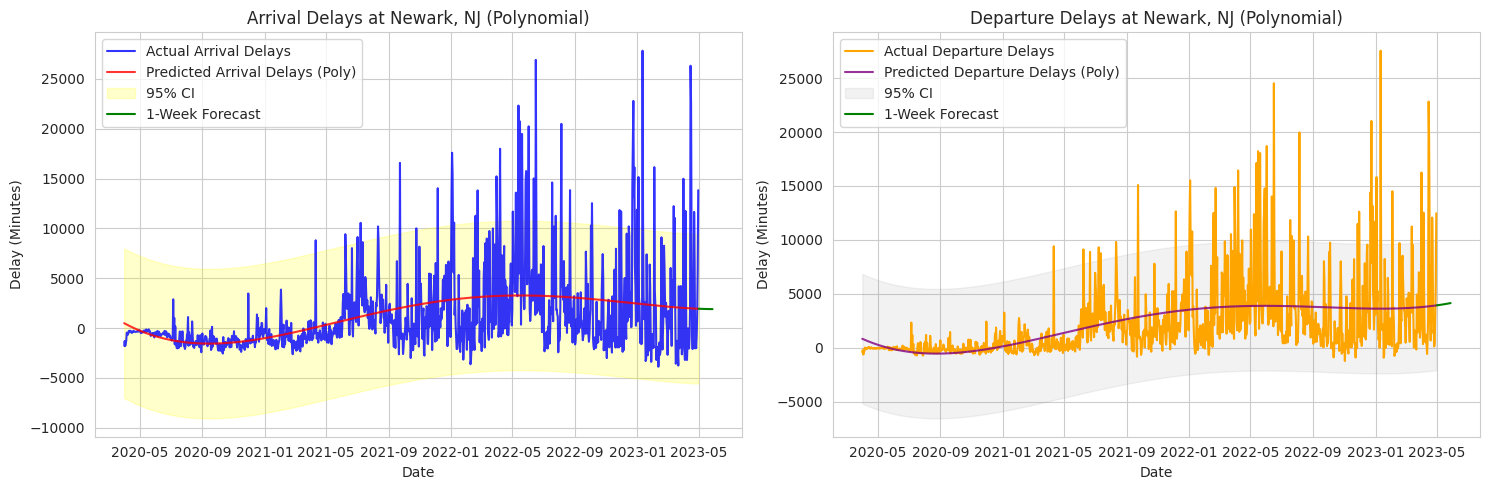

<Figure size 640x480 with 0 Axes>

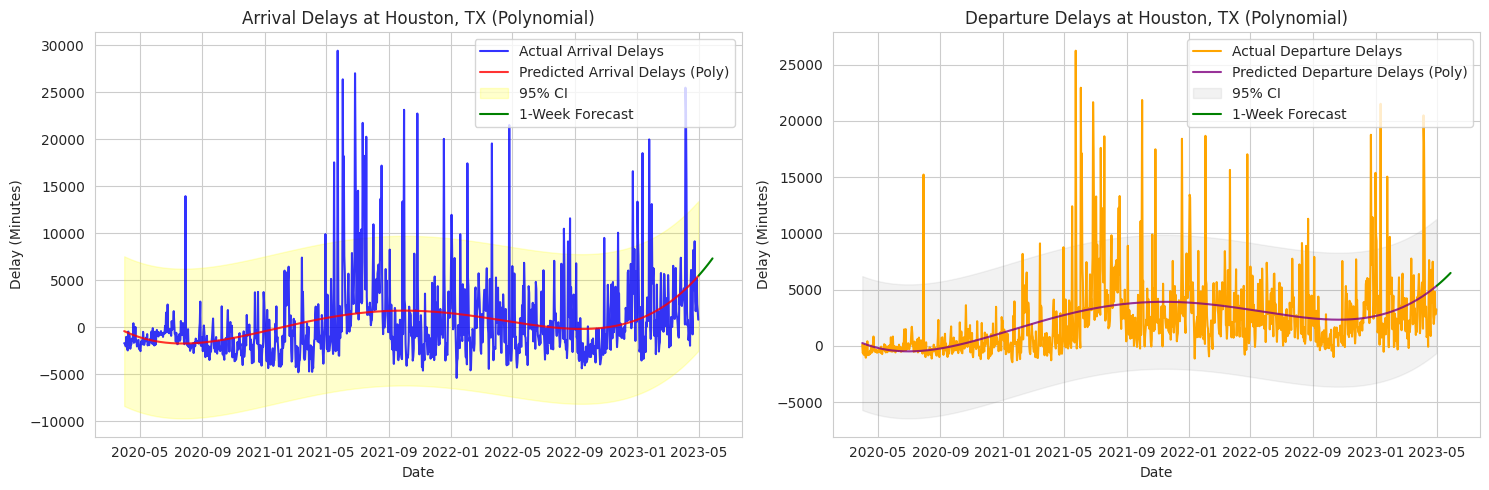

<Figure size 640x480 with 0 Axes>

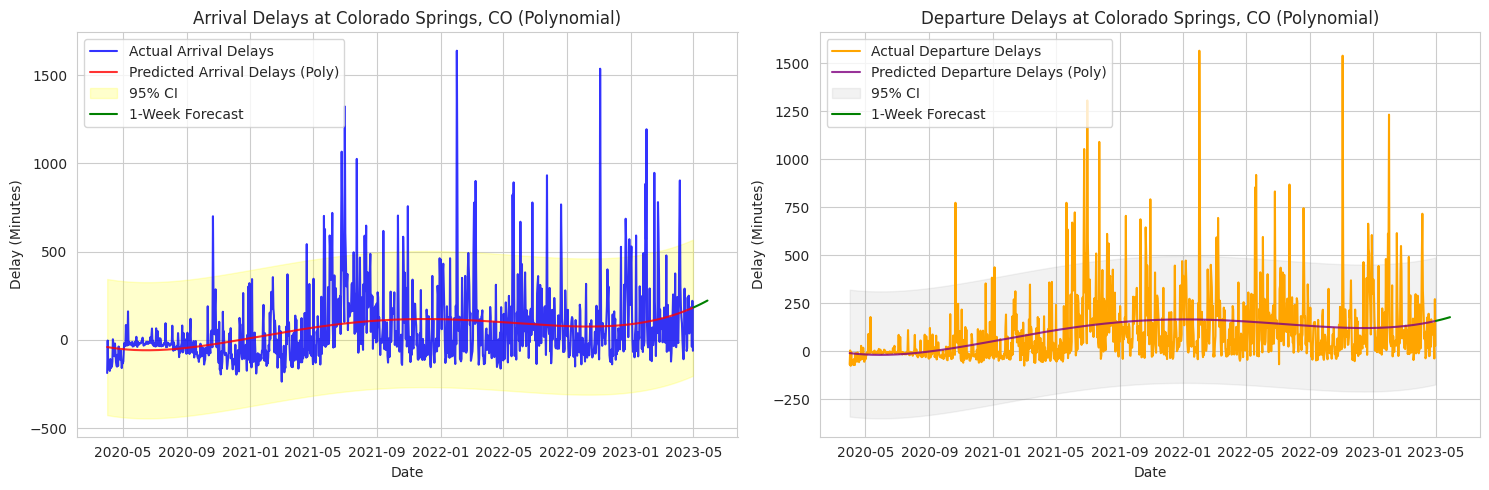

<Figure size 640x480 with 0 Axes>

In [208]:
# Degree of polynomial
poly_degree = 4  # Adjust as needed

# Train Polynomial Regression models
models = {}

for airport in top_airport_names:
    airport_data = delays_by_airport_date[delays_by_airport_date['destination'] == airport]

    X = airport_data[['date_index']]

    # Transform X for polynomial regression
    poly = PolynomialFeatures(degree=poly_degree)
    X_poly = poly.fit_transform(X)

    # Train for arrival delays
    y_arrival = airport_data['arr_delay']
    model_arr = LinearRegression()
    model_arr.fit(X_poly, y_arrival)

    # Compute residuals & standard deviation for confidence interval
    y_arr_pred = model_arr.predict(X_poly)
    residuals_arr = y_arrival - y_arr_pred
    std_arr = np.std(residuals_arr)

    # Train for departure delays
    y_departure = airport_data['dep_delay']
    model_dep = LinearRegression()
    model_dep.fit(X_poly, y_departure)

    # Compute residuals & standard deviation for confidence interval
    y_dep_pred = model_dep.predict(X_poly)
    residuals_dep = y_departure - y_dep_pred
    std_dep = np.std(residuals_dep)

    models[airport] = {
        'arrival': model_arr,
        'departure': model_dep,
        'std_arr': std_arr,
        'std_dep': std_dep,
        'poly': poly  # Store the polynomial transformer for later use
    }

# Plot using subplots for each airport
plt.ion()  # Turn on interactive mode

for airport in top_airport_names:
    airport_data = delays_by_airport_date[delays_by_airport_date['destination'] == airport]
    X = airport_data[['date_index']]

    poly = models[airport]['poly']
    X_poly = poly.transform(X)

    y_actual_arr = airport_data['arr_delay']
    y_actual_dep = airport_data['dep_delay']

    y_pred_arr = models[airport]['arrival'].predict(X_poly)
    y_pred_dep = models[airport]['departure'].predict(X_poly)

    std_arr = models[airport]['std_arr']
    std_dep = models[airport]['std_dep']

    # Generate 1-week forecast
    last_date_index = X.iloc[-1, 0]
    future_dates = pd.DataFrame({'date_index': np.arange(last_date_index + 1, last_date_index + 29)})  # Convert to DataFrame
    #future_dates = np.arange(last_date_index + 1, last_date_index + 8).reshape(-1, 1)
    future_dates_poly = poly.transform(future_dates)
    future_arr_pred = models[airport]['arrival'].predict(future_dates_poly)
    future_dep_pred = models[airport]['departure'].predict(future_dates_poly)


    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Arrival Delays
    axes[0].plot(airport_data['date'], y_actual_arr, label="Actual Arrival Delays", color='blue', alpha=0.8)
    axes[0].plot(airport_data['date'], y_pred_arr, label="Predicted Arrival Delays (Poly)", color='red', linestyle='-', alpha=0.8)

    # Confidence Interval
    axes[0].fill_between(airport_data['date'], y_pred_arr - 1.96 * std_arr, y_pred_arr + 1.96 * std_arr, color='yellow', alpha=0.2, label="95% CI")

    # 1-week forecast
    forecast_dates = pd.date_range(start=airport_data['date'].iloc[-1], periods=29, freq='D')[1:]
    axes[0].plot(forecast_dates, future_arr_pred, label="1-Week Forecast", color='green', linestyle='-')

    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Delay (Minutes)")
    axes[0].set_title(f"Arrival Delays at {airport} (Polynomial)")
    axes[0].legend()
    axes[0].grid(True)

    # Departure Delays
    axes[1].plot(airport_data['date'], y_actual_dep, label="Actual Departure Delays", color='orange')
    axes[1].plot(airport_data['date'], y_pred_dep, label="Predicted Departure Delays (Poly)", color='purple', linestyle='-', alpha=0.8)

    # Confidence Interval
    axes[1].fill_between(airport_data['date'], y_pred_dep - 1.96 * std_dep, y_pred_dep + 1.96 * std_dep, color='grey', alpha=0.1, label="95% CI")

    # 1-week forecast
    axes[1].plot(forecast_dates, future_dep_pred, label="1-Week Forecast", color='green', linestyle='-')

    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Delay (Minutes)")
    axes[1].set_title(f"Departure Delays at {airport} (Polynomial)")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.draw()
    plt.pause(1)
    plt.clf()

plt.ioff()


In [209]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])  # Past 'n' days
        y.append(data[i + n_steps])  # Predict next day
    return np.array(X), np.array(y)

n_steps = 10  # Use the last 10 days to predict the next day
X_arr, y_arr = create_sequences(y_val1.values.reshape(-1, 1), n_steps)
X_dep, y_dep = create_sequences(y_val2.values.reshape(-1, 1), n_steps)

# Reshape for LSTM input: (samples, time_steps, features)
X_arr = X_arr.reshape((X_arr.shape[0], X_arr.shape[1], 1))
X_dep = X_dep.reshape((X_dep.shape[0], X_dep.shape[1], 1))


In [210]:
def build_cnn_lstm(input_shape):
    model = Sequential([
        Input(shape=input_shape),  # Define input layer explicitly

        # CNN Layers to extract spatial features
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),

        # Ensure LSTM gets a proper 3D input by using TimeDistributed(Dense(...))
        TimeDistributed(Dense(32, activation='relu')),

        # LSTM Layers for temporal dependencies
        LSTM(50, activation='relu', return_sequences=True),
        LSTM(50, activation='relu', return_sequences=False),  # Last LSTM should return False

        # Fully Connected Layers
        Dense(25, activation='relu'),
        Dense(1)  # Output layer (regression output: delay value)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Define correct input shape
input_shape = (n_steps, 1)  # (time_steps, features)

# Create models for Arrival and Departure delays
cnn_lstm_model_arr = build_cnn_lstm(input_shape)
cnn_lstm_model_dep = build_cnn_lstm(input_shape)

In [211]:
# Convert the time-series data into sequences for LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])  # Past 'n' days
        y.append(data[i + n_steps])  # Predict next day
    return np.array(X), np.array(y)

n_steps = 10  # Use last 10 days to predict the next day

# Creating sequences for Arrival Delays
X_arr, y_arr = create_sequences(y_val1.values.reshape(-1, 1), n_steps)
X_dep, y_dep = create_sequences(y_val2.values.reshape(-1, 1), n_steps)

# Reshape for LSTM input: (samples, time_steps, features)
X_arr = X_arr.reshape((X_arr.shape[0], X_arr.shape[1], 1))
X_dep = X_dep.reshape((X_dep.shape[0], X_dep.shape[1], 1))

# Split into training and testing sets
X_train_arr, X_test_arr, y_train_arr, y_test_arr = train_test_split(X_arr, y_arr, test_size=0.2, shuffle=False)
X_train_dep, X_test_dep, y_train_dep, y_test_dep = train_test_split(X_dep, y_dep, test_size=0.2, shuffle=False)


In [212]:
print(f"X_train_arr shape: {X_train_arr.shape}, y_train_arr shape: {y_train_arr.shape}")
print(f"X_test_arr shape: {X_test_arr.shape}, y_test_arr shape: {y_test_arr.shape}")


X_train_arr shape: (725, 10, 1), y_train_arr shape: (725, 1)
X_test_arr shape: (182, 10, 1), y_test_arr shape: (182, 1)


In [213]:
history_arr = cnn_lstm_model_arr.fit(
    X_train_arr, y_train_arr,
    epochs=50, batch_size=16,
    validation_data=(X_test_arr, y_test_arr),
    verbose=1
)

history_dep = cnn_lstm_model_dep.fit(
    X_train_dep, y_train_dep,
    epochs=50, batch_size=16,
    validation_data=(X_test_dep, y_test_dep),
    verbose=1
)


Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 1150393728.0000 - mae: 24679.3926 - val_loss: 1644149888.0000 - val_mae: 27816.6270
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 801289536.0000 - mae: 21498.3906 - val_loss: 1614057344.0000 - val_mae: 28752.5527
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 834545984.0000 - mae: 21632.7168 - val_loss: 1564562560.0000 - val_mae: 27793.7031
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 920531328.0000 - mae: 23401.5664 - val_loss: 1575420288.0000 - val_mae: 28064.2637
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 716796800.0000 - mae: 20537.0879 - val_loss: 1560120832.0000 - val_mae: 26426.9199
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 733954304.0000 - mae: 20998.6777 - val_loss: 1562674176.0000 - val_mae: 26576.9336
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 775675904.0000 - mae: 20696.6074 - val_loss: 1521288832.0000 - val_mae: 26171.4980
Epoc

In [214]:


# Predicting on test data
y_pred_cnn_lstm_arr = cnn_lstm_model_arr.predict(X_test_arr)
y_pred_cnn_lstm_dep = cnn_lstm_model_dep.predict(X_test_dep)

# Calculating RMSE
rmse_cnn_lstm_arr = np.sqrt(mean_squared_error(y_test_arr, y_pred_cnn_lstm_arr))
rmse_cnn_lstm_dep = np.sqrt(mean_squared_error(y_test_dep, y_pred_cnn_lstm_dep))

print(f"RMSE for CNN-LSTM Arrival Delays: {rmse_cnn_lstm_arr:.2f}")
print(f"RMSE for CNN-LSTM Departure Delays: {rmse_cnn_lstm_dep:.2f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
RMSE for CNN-LSTM Arrival Delays: 40715.90
RMSE for CNN-LSTM Departure Delays: 34328.19


## CNN-LSTM Prediction for United Airlines

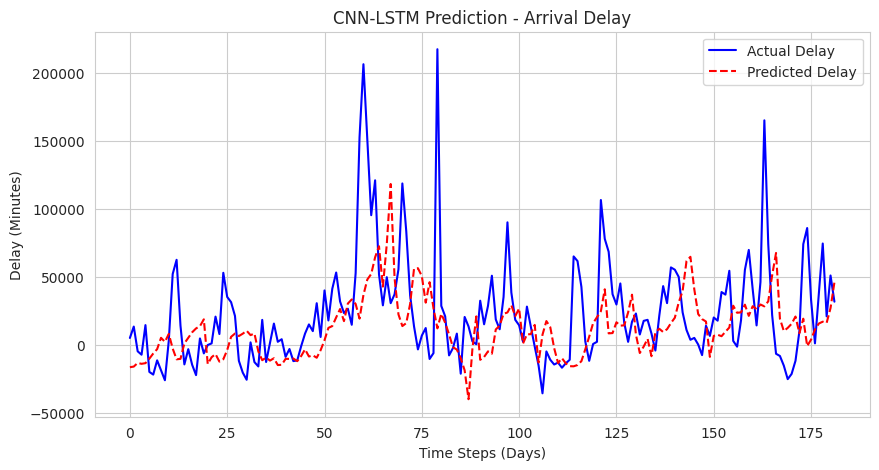

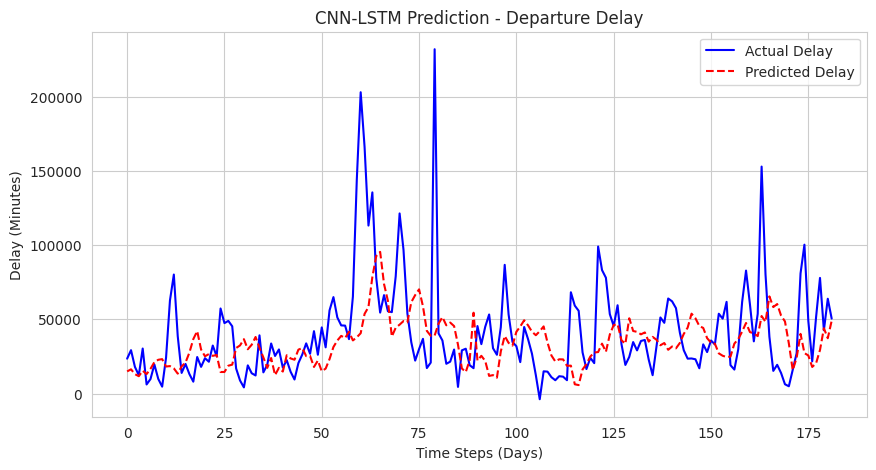

In [215]:
# Function to plot actual vs predicted delays
def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(10, 5))
    plt.plot(y_true, label='Actual Delay', color='blue')
    plt.plot(y_pred, label='Predicted Delay', color='red', linestyle='dashed')
    plt.xlabel("Time Steps (Days)")
    plt.ylabel("Delay (Minutes)")
    plt.title(title)
    plt.legend()
    plt.show()

# Plot results for arrival and departure delays
plot_results(y_test_arr, y_pred_cnn_lstm_arr, "CNN-LSTM Prediction - Arrival Delay")
plot_results(y_test_dep, y_pred_cnn_lstm_dep, "CNN-LSTM Prediction - Departure Delay")

In [216]:
print(f" RMSE Comparison:")
print(f"Linear Regression (Arrival): {rmse_lm_arr:.2f}")
print(f"Polynomial Regression (Arrival): {rmse_poly_arr:.2f}")
print(f"CNN-LSTM (Arrival): {rmse_cnn_lstm_arr:.2f}")

print(f"Linear Regression (Departure): {rmse_lm_dep:.2f}")
print(f"Polynomial Regression (Departure): {rmse_poly_dep:.2f}")
print(f"CNN-LSTM (Departure): {rmse_cnn_lstm_dep:.2f}")


 RMSE Comparison:
Linear Regression (Arrival): 33136.43
Polynomial Regression (Arrival): 31615.28
CNN-LSTM (Arrival): 40715.90
Linear Regression (Departure): 27594.95
Polynomial Regression (Departure): 25936.30
CNN-LSTM (Departure): 34328.19


In [217]:
# Attention layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        query, value = inputs, inputs
        attention = Attention()([query, value])  # Compute attention
        return attention


In [218]:
def build_att_bi_lstm(input_shape):
    input_layer = Input(shape=input_shape)

    # CNN Layers (same as previous)
    conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
    conv1_bn = BatchNormalization()(conv1)
    conv2 = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(conv1_bn)
    conv2_bn = BatchNormalization()(conv2)

    # Bidirectional LSTM Layer
    bi_lstm = Bidirectional(LSTM(50, activation='relu', return_sequences=True))(conv2_bn)

    # Attention Layer
    attention = AttentionLayer()(bi_lstm)

    # Concatenate the attention output with the Bidirectional LSTM output
    lstm_att_output = Concatenate()([bi_lstm, attention])

    # Additional LSTM Layer
    lstm_final = LSTM(50, activation='relu', return_sequences=False)(lstm_att_output)

    # Fully Connected Layers (same as previous)
    dense1 = Dense(25, activation='relu')(lstm_final)
    output_layer = Dense(1)(dense1)

    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [219]:
# Define the model
att_bi_lstm_model_arr = build_att_bi_lstm(input_shape)
att_bi_lstm_model_dep = build_att_bi_lstm(input_shape)

# Train the models
history_att_bi_lstm_arr = att_bi_lstm_model_arr.fit(
    X_train_arr, y_train_arr,
    epochs=50, batch_size=16,
    validation_data=(X_test_arr, y_test_arr),
    verbose=1
)

history_att_bi_lstm_dep = att_bi_lstm_model_dep.fit(
    X_train_dep, y_train_dep,
    epochs=50, batch_size=16,
    validation_data=(X_test_dep, y_test_dep),
    verbose=1
)


Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 1204362752.0000 - mae: 25123.2812 - val_loss: 1660053376.0000 - val_mae: 26515.6758
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 825113728.0000 - mae: 20563.9199 - val_loss: 1355460352.0000 - val_mae: 23547.1758
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 644569920.0000 - mae: 18728.3047 - val_loss: 1182700416.0000 - val_mae: 23890.2109
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 561237632.0000 - mae: 17707.9707 - val_loss: 1217417216.0000 - val_mae: 24601.8828
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 607382464.0000 - mae: 17616.1992 - val_loss: 1200443776.0000 - val_mae: 24110.3535
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 587924032.0000 - mae: 18809.3594 - val_loss: 1157892992.0000 - val_mae: 22826.7324
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 546275904.0000 - mae: 17586.5996 - val_loss: 1271953536.0000 - val_mae: 24240.0605
Epoch

In [220]:
# Predicting on test data
y_pred_att_bi_lstm_arr = att_bi_lstm_model_arr.predict(X_test_arr)
y_pred_att_bi_lstm_dep = att_bi_lstm_model_dep.predict(X_test_dep)

# Calculating RMSE
rmse_att_bi_lstm_arr = np.sqrt(mean_squared_error(y_test_arr, y_pred_att_bi_lstm_arr))
rmse_att_bi_lstm_dep = np.sqrt(mean_squared_error(y_test_dep, y_pred_att_bi_lstm_dep))

print(f"RMSE for ATT-BI-LSTM Arrival Delays: {rmse_att_bi_lstm_arr:.2f}")
print(f"RMSE for ATT-BI-LSTM Departure Delays: {rmse_att_bi_lstm_dep:.2f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
RMSE for ATT-BI-LSTM Arrival Delays: 32611.04
RMSE for ATT-BI-LSTM Departure Delays: 32155.74


## ATT-BI-LSTM Prediction for United Airlines

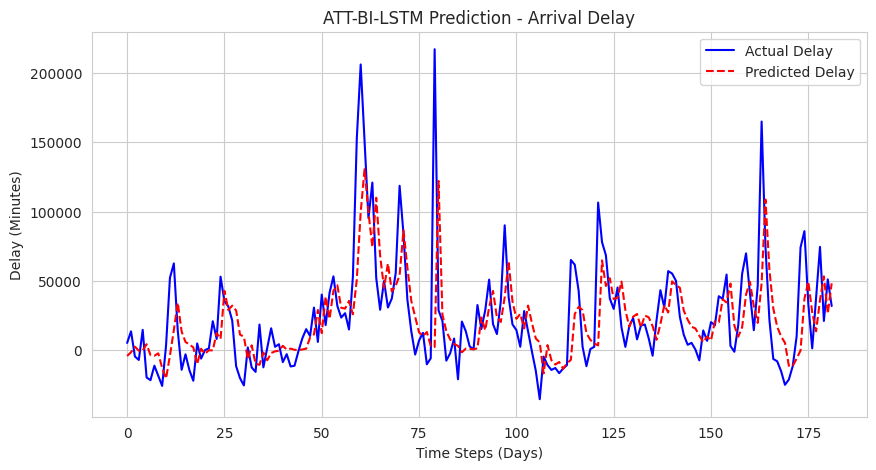

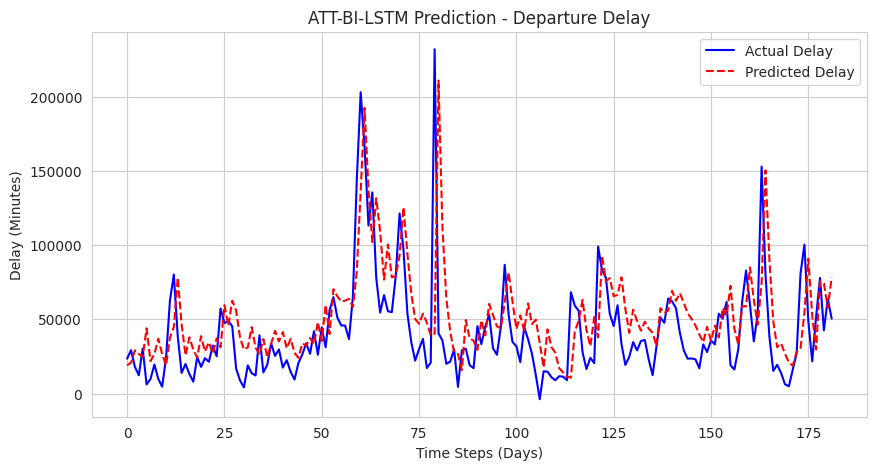

In [221]:
# Plot results for arrival and departure delays
plot_results(y_test_arr, y_pred_att_bi_lstm_arr, "ATT-BI-LSTM Prediction - Arrival Delay")
plot_results(y_test_dep, y_pred_att_bi_lstm_dep, "ATT-BI-LSTM Prediction - Departure Delay")

In [222]:
print(f"RMSE Comparison:")
print(f"Linear Regression (Arrival): {rmse_lm_arr:.2f}")
print(f"Polynomial Regression (Arrival): {rmse_poly_arr:.2f}")
print(f"CNN-LSTM (Arrival): {rmse_cnn_lstm_arr:.2f}")
print(f"ATT-BI-LSTM (Arrival): {rmse_att_bi_lstm_arr:.2f}")
print()
print(f"Linear Regression (Departure): {rmse_lm_dep:.2f}")
print(f"Polynomial Regression (Departure): {rmse_poly_dep:.2f}")
print(f"CNN-LSTM (Departure): {rmse_cnn_lstm_dep:.2f}")
print(f"ATT-BI-LSTM (Departure): {rmse_att_bi_lstm_dep:.2f}")


RMSE Comparison:
Linear Regression (Arrival): 33136.43
Polynomial Regression (Arrival): 31615.28
CNN-LSTM (Arrival): 40715.90
ATT-BI-LSTM (Arrival): 32611.04

Linear Regression (Departure): 27594.95
Polynomial Regression (Departure): 25936.30
CNN-LSTM (Departure): 34328.19
ATT-BI-LSTM (Departure): 32155.74


In [223]:
# Function to build a Random Forest model for regression
def build_rf_model():
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    return model


In [224]:
# Reshape the data from (samples, time_steps, features) to (samples, features)
X_train_arr_flat = X_train_arr.reshape(X_train_arr.shape[0], -1)
X_test_arr_flat = X_test_arr.reshape(X_test_arr.shape[0], -1)

X_train_dep_flat = X_train_dep.reshape(X_train_dep.shape[0], -1)
X_test_dep_flat = X_test_dep.reshape(X_test_dep.shape[0], -1)


In [225]:
# Define the Random Forest models for arrival and departure delays
rf_model_arr = build_rf_model()
rf_model_dep = build_rf_model()

# Train the Random Forest models
rf_model_arr.fit(X_train_arr_flat, y_train_arr)
rf_model_dep.fit(X_train_dep_flat, y_train_dep)



/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=42)

In [226]:
# Make predictions on the test data
y_pred_rf_arr = rf_model_arr.predict(X_test_arr_flat)
y_pred_rf_dep = rf_model_dep.predict(X_test_dep_flat)

# Calculate RMSE for both arrival and departure delays
rmse_rf_arr = np.sqrt(mean_squared_error(y_test_arr, y_pred_rf_arr))
rmse_rf_dep = np.sqrt(mean_squared_error(y_test_dep, y_pred_rf_dep))

print(f"RMSE for Random Forest Arrival Delays: {rmse_rf_arr:.2f}")
print(f"RMSE for Random Forest Departure Delays: {rmse_rf_dep:.2f}")



RMSE for Random Forest Arrival Delays: 33406.96
RMSE for Random Forest Departure Delays: 27979.48


## Random Forest Prediction for United Airlines

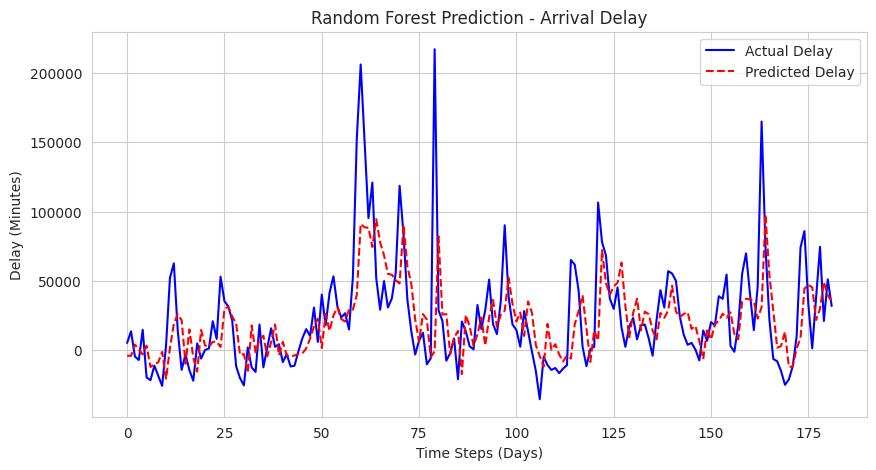

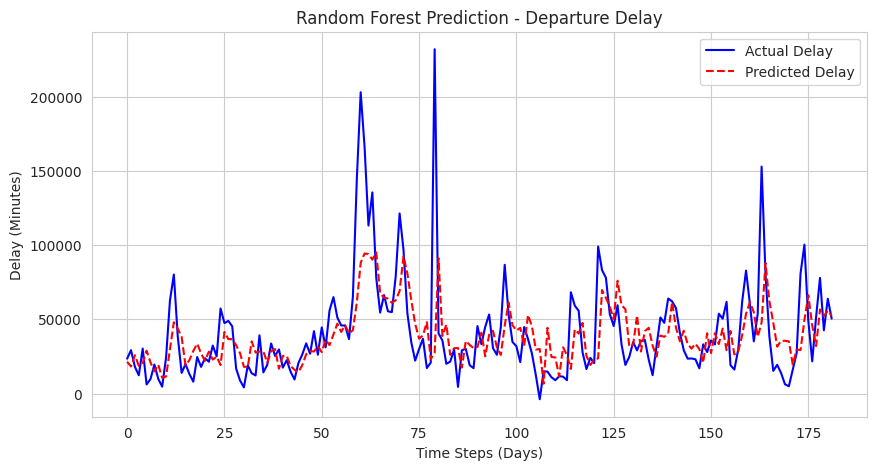

In [227]:
# Plot results for arrival and departure delays
plot_results(y_test_arr, y_pred_rf_arr, "Random Forest Prediction - Arrival Delay")
plot_results(y_test_dep, y_pred_rf_dep, "Random Forest Prediction - Departure Delay")

In [228]:
# Assuming X_arr, y_arr, X_dep, y_dep are already created as in your code
# For example, X_arr (features) and y_arr (target values for arrival delays)
X_train_arr, X_test_arr, y_train_arr, y_test_arr = train_test_split(X_arr.reshape(X_arr.shape[0], -1), y_arr, test_size=0.2, shuffle=False)
X_train_dep, X_test_dep, y_train_dep, y_test_dep = train_test_split(X_dep.reshape(X_dep.shape[0], -1), y_dep, test_size=0.2, shuffle=False)


In [229]:
# Initialize Gradient Boosting Regressor
gbm_arr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm_dep = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the models
gbm_arr.fit(X_train_arr, y_train_arr)
gbm_dep.fit(X_train_dep, y_train_dep)


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GradientBoostingRegressor(random_state=42)

In [230]:
# Predictions on test data
y_pred_gbm_arr = gbm_arr.predict(X_test_arr)
y_pred_gbm_dep = gbm_dep.predict(X_test_dep)

# Calculate RMSE
rmse_gbm_arr = np.sqrt(mean_squared_error(y_test_arr, y_pred_gbm_arr))
rmse_gbm_dep = np.sqrt(mean_squared_error(y_test_dep, y_pred_gbm_dep))

print(f"RMSE for Gradient Boosting Arrival Delays: {rmse_gbm_arr:.2f}")
print(f"RMSE for Gradient Boosting Departure Delays: {rmse_gbm_dep:.2f}")


RMSE for Gradient Boosting Arrival Delays: 32604.74
RMSE for Gradient Boosting Departure Delays: 28090.69


## Gradient Boosting Prediction for United Airlines

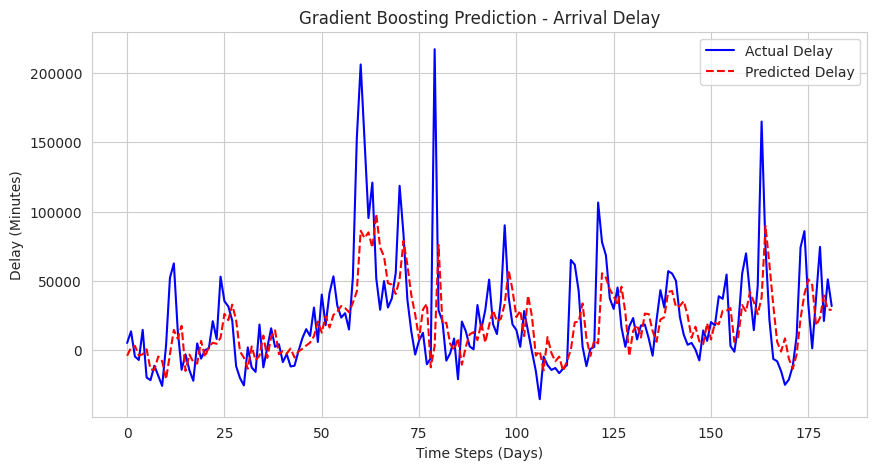

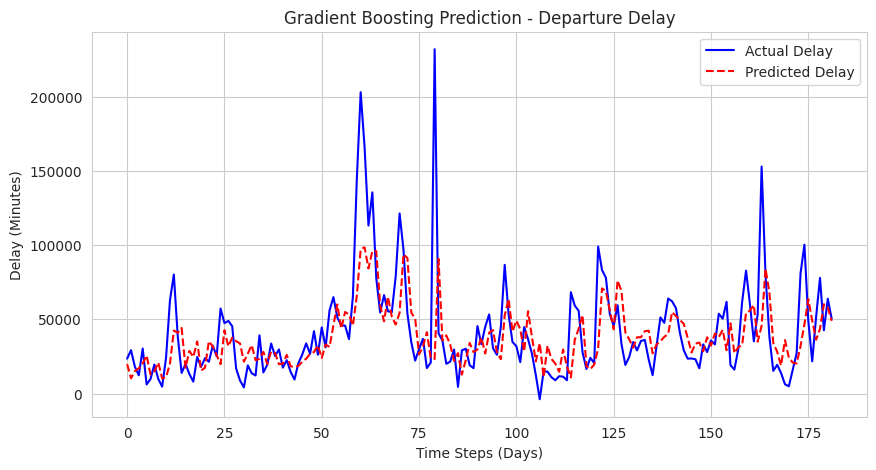

In [231]:
# Function to plot actual vs predicted delays
def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(10, 5))
    plt.plot(y_true, label='Actual Delay', color='blue')
    plt.plot(y_pred, label='Predicted Delay', color='red', linestyle='dashed')
    plt.xlabel("Time Steps (Days)")
    plt.ylabel("Delay (Minutes)")
    plt.title(title)
    plt.legend()
    plt.show()

# Plot results for GBM models
plot_results(y_test_arr, y_pred_gbm_arr, "Gradient Boosting Prediction - Arrival Delay")
plot_results(y_test_dep, y_pred_gbm_dep, "Gradient Boosting Prediction - Departure Delay")


In [232]:
# Flatten the sequence data into 2D for XGBoost
def flatten_sequences(X):
    # Flatten each sequence (n_steps, 1) into a 1D vector
    return X.reshape(X.shape[0], -1)

# Flatten the arrival and departure data
X_arr_flat = flatten_sequences(X_arr)
X_dep_flat = flatten_sequences(X_dep)

# Split the data into training and testing sets (80-20 split)
X_train_arr, X_test_arr, y_train_arr, y_test_arr = train_test_split(X_arr_flat, y_arr, test_size=0.2, shuffle=False)
X_train_dep, X_test_dep, y_train_dep, y_test_dep = train_test_split(X_dep_flat, y_dep, test_size=0.2, shuffle=False)

In [233]:
# Example of adjusting hyperparameters
xgb_model_arr = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=200,  # Increase the number of trees
                                 max_depth=10,       # Increase the depth of trees
                                 learning_rate=0.1,
                                 subsample=0.8,
                                 colsample_bytree=0.8)


# Train the model
xgb_model_arr.fit(X_train_arr, y_train_arr)

# Make predictions
y_pred_xgb_arr = xgb_model_arr.predict(X_test_arr)
rmse_xgb_arr = np.sqrt(mean_squared_error(y_test_arr, y_pred_xgb_arr))
print(f"RMSE for XGBoost (Arrival Delays): {rmse_xgb_arr:.2f}")


RMSE for XGBoost (Arrival Delays): 33816.40


In [234]:
# Initialize and train XGBoost model for Departure delays
xgb_model_dep = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=100,
                                 max_depth=6,
                                 learning_rate=0.1,
                                 subsample=0.8,
                                 colsample_bytree=0.8)

# Train the model
xgb_model_dep.fit(X_train_dep, y_train_dep)

# Make predictions
y_pred_xgb_dep = xgb_model_dep.predict(X_test_dep)

# Calculate RMSE for Departure delays
rmse_xgb_dep = np.sqrt(mean_squared_error(y_test_dep, y_pred_xgb_dep))
print(f"RMSE for XGBoost (Departure Delays): {rmse_xgb_dep:.2f}")


RMSE for XGBoost (Departure Delays): 27223.88


## XGBoost Prediction Prediction for United Airlines

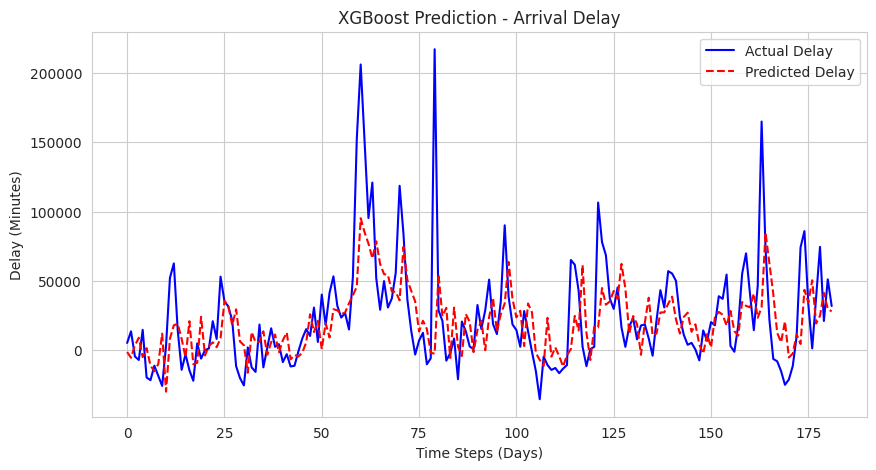

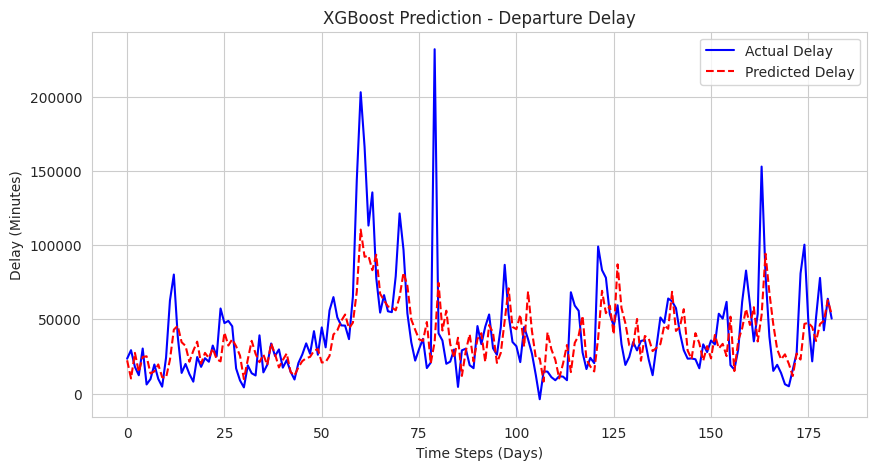

In [235]:
# Function to plot actual vs predicted delays
def plot_results1(y_true, y_pred, title):
    plt.figure(figsize=(10, 5))
    plt.plot(y_true, label='Actual Delay', color='blue')
    plt.plot(y_pred, label='Predicted Delay', color='red', linestyle='dashed')
    plt.xlabel("Time Steps (Days)")
    plt.ylabel("Delay (Minutes)")
    plt.title(title)
    plt.legend()
    plt.show()

# Plot results for arrival and departure delays (XGBoost)
plot_results1(y_test_arr, y_pred_xgb_arr, "XGBoost Prediction - Arrival Delay")
plot_results1(y_test_dep, y_pred_xgb_dep, "XGBoost Prediction - Departure Delay")


In [236]:
print(f"RMSE Comparison:")
print(f"Linear Regression (Arrival): {rmse_lm_arr:.2f}")
print(f"Polynomial Regression (Arrival): {rmse_poly_arr:.2f}")
print(f"CNN-LSTM (Arrival): {rmse_cnn_lstm_arr:.2f}")
print(f"ATT-BI-LSTM (Arrival): {rmse_att_bi_lstm_arr:.2f}")
print(f"RMSE for Random Forest for Arrival Delays: {rmse_rf_arr:.2f}")
print(f"RMSE for XGBoost (Arrival): {rmse_xgb_arr:.2f}")
print()

print(f"Linear Regression (Departure): {rmse_lm_dep:.2f}")
print(f"Polynomial Regression (Departure): {rmse_poly_dep:.2f}")
print(f"CNN-LSTM (Departure): {rmse_cnn_lstm_dep:.2f}")
print(f"RMSE for Random Forest for Departure Delays: {rmse_rf_dep:.2f}")
print(f"ATT-BI-LSTM (Departure): {rmse_att_bi_lstm_dep:.2f}")
print(f"RMSE for XGBoost (Departure): {rmse_xgb_dep:.2f}")

RMSE Comparison:
Linear Regression (Arrival): 33136.43
Polynomial Regression (Arrival): 31615.28
CNN-LSTM (Arrival): 40715.90
ATT-BI-LSTM (Arrival): 32611.04
RMSE for Random Forest for Arrival Delays: 33406.96
RMSE for XGBoost (Arrival): 33816.40

Linear Regression (Departure): 27594.95
Polynomial Regression (Departure): 25936.30
CNN-LSTM (Departure): 34328.19
RMSE for Random Forest for Departure Delays: 27979.48
ATT-BI-LSTM (Departure): 32155.74
RMSE for XGBoost (Departure): 27223.88


In [237]:
def plot_arrival_delay(x_val, y_true_arr,
                       y_pred_lm_arr, y_pred_poly_arr,
                       y_pred_rf_arr, y_pred_cnn_lstm_arr,
                       y_pred_att_bi_lstm_arr, title_arr):
    # Create a new figure for Arrival Delay Predictions
    plt.figure(figsize=(12, 6))

    # Plot Arrival Delay Predictions (Actual vs Multiple Models)
    plt.plot(x_val, y_true_arr, label='Actual Arrival Delay', color='blue', linewidth=2)
    plt.plot(x_val, y_pred_lm_arr, label='Linear Regression', color='red', linestyle='-')
    plt.plot(x_val, y_pred_poly_arr, label='Polynomial Regression', color='brown', linestyle='-')
    plt.plot(x_val, y_pred_rf_arr, label='Random Forest', color='purple', linestyle='dashed')
    plt.plot(x_val, y_pred_cnn_lstm_arr, label='CNN-LSTM', color='orange', linestyle='dashed')
    plt.plot(x_val, y_pred_att_bi_lstm_arr, label='ATT-BI-LSTM', color='green', linestyle='dashed')

    plt.xlabel("Time Steps (Days)")
    plt.ylabel("Arrival Delay (Minutes)")
    plt.title(title_arr)
    plt.legend()

    plt.tight_layout()
    plt.show()


In [238]:
def plot_departure_delay(x_val, y_true_dep,
                         y_pred_lm_dep, y_pred_poly_dep,
                         y_pred_rf_dep, y_pred_cnn_lstm_dep,
                         y_pred_att_bi_lstm_dep, title_dep):
    # Create a new figure for Departure Delay Predictions
    plt.figure(figsize=(12, 6))

    # Plot Departure Delay Predictions (Actual vs Multiple Models)
    plt.plot(x_val, y_true_dep, label='Actual Departure Delay', color='blue', linewidth=2)
    plt.plot(x_val, y_pred_lm_dep, label='Linear Regression', color='red', linestyle='-')
    plt.plot(x_val, y_pred_poly_dep, label='Polynomial Regression', color='brown', linestyle='-')
    plt.plot(x_val, y_pred_rf_dep, label='Random Forest', color='purple', linestyle='dashed')
    plt.plot(x_val, y_pred_cnn_lstm_dep, label='CNN-LSTM', color='orange', linestyle='dashed')
    plt.plot(x_val, y_pred_att_bi_lstm_dep, label='ATT-BI-LSTM', color='green', linestyle='dashed')

    plt.xlabel("Time Steps (Days)")
    plt.ylabel("Departure Delay (Minutes)")
    plt.title(title_dep)
    plt.legend()

    plt.tight_layout()
    plt.show()


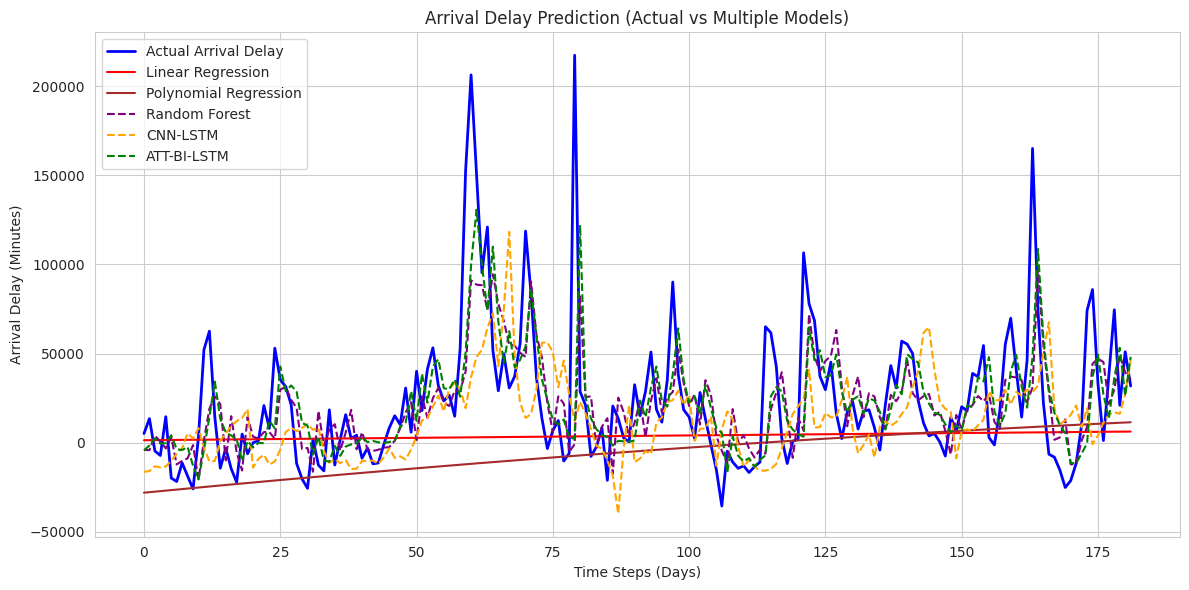

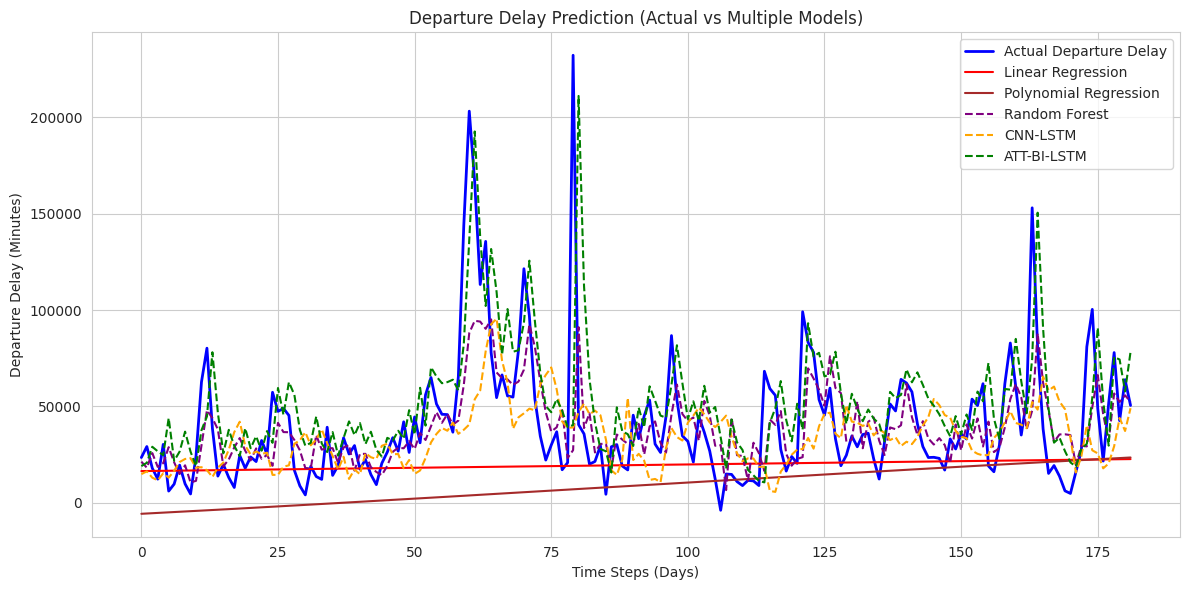

In [239]:
# Resize x_val to match the number of samples in y_test_arr and y_test_dep
x_val_resized = x_val[:len(y_test_arr)]  # Ensure x_val matches the length of y_test_arr

# Resize the prediction arrays
y_pred_lm_arr_resized = y_pred_lm_arr[:len(y_test_arr)]
y_pred_lm_dep_resized = y_pred_lm_dep[:len(y_test_dep)]
y_pred_poly_arr_resized = y_pred_poly_arr[:len(y_test_arr)]
y_pred_poly_dep_resized = y_pred_poly_dep[:len(y_test_dep)]
y_pred_rf_arr_resized = y_pred_rf_arr[:len(y_test_arr)]
y_pred_rf_dep_resized = y_pred_rf_dep[:len(y_test_dep)]
y_pred_cnn_lstm_arr_resized = y_pred_cnn_lstm_arr[:len(y_test_arr)]
y_pred_cnn_lstm_dep_resized = y_pred_cnn_lstm_dep[:len(y_test_dep)]
y_pred_att_bi_lstm_arr_resized = y_pred_att_bi_lstm_arr[:len(y_test_arr)]
y_pred_att_bi_lstm_dep_resized = y_pred_att_bi_lstm_dep[:len(y_test_dep)]

# Plot Arrival Delay
plot_arrival_delay(
    x_val_resized,
    y_test_arr,
    y_pred_lm_arr_resized, y_pred_poly_arr_resized,
    y_pred_rf_arr_resized, y_pred_cnn_lstm_arr_resized,
    y_pred_att_bi_lstm_arr_resized,
    "Arrival Delay Prediction (Actual vs Multiple Models)"
)

# Plot Departure Delay
plot_departure_delay(
    x_val_resized,
    y_test_dep,
    y_pred_lm_dep_resized, y_pred_poly_dep_resized,
    y_pred_rf_dep_resized, y_pred_cnn_lstm_dep_resized,
    y_pred_att_bi_lstm_dep_resized,
    "Departure Delay Prediction (Actual vs Multiple Models)"
)


In [240]:
print(f" RMSE Comparison:")
print(f"Linear Regression (Arrival): {rmse_lm_arr:.2f}")
print(f"Polynomial Regression (Arrival): {rmse_poly_arr:.2f}")
print(f"CNN-LSTM (Arrival): {rmse_cnn_lstm_arr:.2f}")
print(f"ATT-BI-LSTM (Arrival): {rmse_att_bi_lstm_arr:.2f}")
print(f"RMSE for Random Forest for Arrival Delays: {rmse_rf_arr:.2f}")
print()
print(f"Linear Regression (Departure): {rmse_lm_dep:.2f}")
print(f"Polynomial Regression (Departure): {rmse_poly_dep:.2f}")
print(f"CNN-LSTM (Departure): {rmse_cnn_lstm_dep:.2f}")
print(f"RMSE for Random Forest for Departure Delays: {rmse_rf_dep:.2f}")
print(f"ATT-BI-LSTM (Departure): {rmse_att_bi_lstm_dep:.2f}")

 RMSE Comparison:
Linear Regression (Arrival): 33136.43
Polynomial Regression (Arrival): 31615.28
CNN-LSTM (Arrival): 40715.90
ATT-BI-LSTM (Arrival): 32611.04
RMSE for Random Forest for Arrival Delays: 33406.96

Linear Regression (Departure): 27594.95
Polynomial Regression (Departure): 25936.30
CNN-LSTM (Departure): 34328.19
RMSE for Random Forest for Departure Delays: 27979.48
ATT-BI-LSTM (Departure): 32155.74


In [241]:
print(f" RMSE Comparison:")
print(f"Linear Regression (Arrival): {rmse_lm_arr:.2f}")
print(f"Polynomial Regression (Arrival): {rmse_poly_arr:.2f}")
print()
print(f"CNN-LSTM (Arrival): {rmse_cnn_lstm_arr:.2f}")
print(f"ATT-BI-LSTM (Arrival): {rmse_att_bi_lstm_arr:.2f}")
print(f"RMSE for Random Forest for Arrival Delays: {rmse_rf_arr:.2f}")
print()
print(f"RMSE for Gradient Boosting Arrival Delays: {rmse_gbm_arr:.2f}")
print(f"RMSE for XGBoost (Arrival): {rmse_xgb_arr:.2f}")

print()
print(f"Linear Regression (Departure): {rmse_lm_dep:.2f}")
print(f"Polynomial Regression (Departure): {rmse_poly_dep:.2f}")
print()
print(f"CNN-LSTM (Departure): {rmse_cnn_lstm_dep:.2f}")
print(f"ATT-BI-LSTM (Departure): {rmse_att_bi_lstm_dep:.2f}")
print(f"RMSE for Random Forest for Departure Delays: {rmse_rf_dep:.2f}")
print()
print(f"RMSE for Gradient Boosting Departure Delays: {rmse_gbm_dep:.2f}")
print(f"RMSE for XGBoost (Departure): {rmse_xgb_dep:.2f}")


 RMSE Comparison:
Linear Regression (Arrival): 33136.43
Polynomial Regression (Arrival): 31615.28

CNN-LSTM (Arrival): 40715.90
ATT-BI-LSTM (Arrival): 32611.04
RMSE for Random Forest for Arrival Delays: 33406.96

RMSE for Gradient Boosting Arrival Delays: 32604.74
RMSE for XGBoost (Arrival): 33816.40

Linear Regression (Departure): 27594.95
Polynomial Regression (Departure): 25936.30

CNN-LSTM (Departure): 34328.19
ATT-BI-LSTM (Departure): 32155.74
RMSE for Random Forest for Departure Delays: 27979.48

RMSE for Gradient Boosting Departure Delays: 28090.69
RMSE for XGBoost (Departure): 27223.88


In [242]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Attention


x_val = np.arange(len(delays_by_date)).reshape(-1, 1)
X_arr = x_val
X_dep = x_val
y_arr = delays_by_date['arr_delay'].values  # Arrival delay target variable
y_dep = delays_by_date['dep_delay'].values  # Departure delay target variable

# Function to flatten the sequence data
def flatten_sequences(X):
    return X.reshape(X.shape[0], -1)

# Train-test split (80% training, 20% testing)
X_train_arr, X_test_arr, y_train_arr, y_test_arr = train_test_split(flatten_sequences(X_arr), y_arr, test_size=0.2, shuffle=False)
X_train_dep, X_test_dep, y_train_dep, y_test_dep = train_test_split(flatten_sequences(X_dep), y_dep, test_size=0.2, shuffle=False)

# --- 1. Random Forest Regressor ---
rf_model_arr = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_dep = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the models
rf_model_arr.fit(X_train_arr, y_train_arr)
rf_model_dep.fit(X_train_dep, y_train_dep)

# Predictions
y_pred_rf_arr = rf_model_arr.predict(X_test_arr)
y_pred_rf_dep = rf_model_dep.predict(X_test_dep)

# RMSE for Random Forest
rmse_rf_arr = np.sqrt(mean_squared_error(y_test_arr, y_pred_rf_arr))
rmse_rf_dep = np.sqrt(mean_squared_error(y_test_dep, y_pred_rf_dep))

# --- 2. Gradient Boosting Regressor ---
gbm_arr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm_dep = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the models
gbm_arr.fit(X_train_arr, y_train_arr)
gbm_dep.fit(X_train_dep, y_train_dep)

# Predictions
y_pred_gbm_arr = gbm_arr.predict(X_test_arr)
y_pred_gbm_dep = gbm_dep.predict(X_test_dep)

# RMSE for Gradient Boosting
rmse_gbm_arr = np.sqrt(mean_squared_error(y_test_arr, y_pred_gbm_arr))
rmse_gbm_dep = np.sqrt(mean_squared_error(y_test_dep, y_pred_gbm_dep))

# --- 3. XGBoost ---
xgb_model_arr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8)
xgb_model_dep = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8)

# Train the models
xgb_model_arr.fit(X_train_arr, y_train_arr)
xgb_model_dep.fit(X_train_dep, y_train_dep)

# Predictions
y_pred_xgb_arr = xgb_model_arr.predict(X_test_arr)
y_pred_xgb_dep = xgb_model_dep.predict(X_test_dep)

# RMSE for XGBoost
rmse_xgb_arr = np.sqrt(mean_squared_error(y_test_arr, y_pred_xgb_arr))
rmse_xgb_dep = np.sqrt(mean_squared_error(y_test_dep, y_pred_xgb_dep))

# --- 4. CNN-LSTM Model ---
def cnn_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Reshaping for LSTM (assuming 3D input required)
X_train_arr_lstm = X_train_arr.reshape((X_train_arr.shape[0], 1, X_train_arr.shape[1]))
X_test_arr_lstm = X_test_arr.reshape((X_test_arr.shape[0], 1, X_test_arr.shape[1]))

X_train_dep_lstm = X_train_dep.reshape((X_train_dep.shape[0], 1, X_train_dep.shape[1]))
X_test_dep_lstm = X_test_dep.reshape((X_test_dep.shape[0], 1, X_test_dep.shape[1]))

cnn_lstm_arr = cnn_lstm_model(X_train_arr_lstm.shape[1:])
cnn_lstm_dep = cnn_lstm_model(X_train_dep_lstm.shape[1:])

# Train the models
cnn_lstm_arr.fit(X_train_arr_lstm, y_train_arr, epochs=10, batch_size=32, verbose=0)
cnn_lstm_dep.fit(X_train_dep_lstm, y_train_dep, epochs=10, batch_size=32, verbose=0)

# Predictions
y_pred_cnn_lstm_arr = cnn_lstm_arr.predict(X_test_arr_lstm)
y_pred_cnn_lstm_dep = cnn_lstm_dep.predict(X_test_dep_lstm)

# RMSE for CNN-LSTM
rmse_cnn_lstm_arr = np.sqrt(mean_squared_error(y_test_arr, y_pred_cnn_lstm_arr))
rmse_cnn_lstm_dep = np.sqrt(mean_squared_error(y_test_dep, y_pred_cnn_lstm_dep))

# --- 5. ATT-BI-LSTM Model ---


def att_bi_lstm_model(input_shape):
    inputs = Input(shape=input_shape)

    # Bi-directional LSTM Layer
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(inputs)

    # Attention Layer
    attention_out = Attention()([lstm_out, lstm_out])  # Query and Value are both lstm_out

    # Dense Layer for output
    output = Dense(1)(attention_out)

    # Create and compile the model
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Example call (ensure X_train_arr_lstm and X_train_dep_lstm are correctly shaped)
att_bi_lstm_arr = att_bi_lstm_model(X_train_arr_lstm.shape[1:])
att_bi_lstm_dep = att_bi_lstm_model(X_train_dep_lstm.shape[1:])


# Train the models
att_bi_lstm_arr.fit(X_train_arr_lstm, y_train_arr, epochs=10, batch_size=32, verbose=0)
att_bi_lstm_dep.fit(X_train_dep_lstm, y_train_dep, epochs=10, batch_size=32, verbose=0)

# Predictions
y_pred_att_bi_lstm_arr = att_bi_lstm_arr.predict(X_test_arr_lstm)
y_pred_att_bi_lstm_dep = att_bi_lstm_dep.predict(X_test_dep_lstm)

# RMSE for ATT-BI-LSTM
# Flatten the predictions
y_pred_att_bi_lstm_arr = y_pred_att_bi_lstm_arr.reshape(-1)
y_pred_att_bi_lstm_dep = y_pred_att_bi_lstm_dep.reshape(-1)

# Flatten the actual values
y_test_arr = y_test_arr.reshape(-1)
y_test_dep = y_test_dep.reshape(-1)

# RMSE for ATT-BI-LSTM
rmse_att_bi_lstm_arr = np.sqrt(mean_squared_error(y_test_arr, y_pred_att_bi_lstm_arr))
rmse_att_bi_lstm_dep = np.sqrt(mean_squared_error(y_test_dep, y_pred_att_bi_lstm_dep))


# --- 6. Linear Regression ---
lin_reg_arr = LinearRegression()
lin_reg_dep = LinearRegression()

# Train the models
lin_reg_arr.fit(X_train_arr, y_train_arr)
lin_reg_dep.fit(X_train_dep, y_train_dep)

# Predictions
y_pred_lin_reg_arr = lin_reg_arr.predict(X_test_arr)
y_pred_lin_reg_dep = lin_reg_dep.predict(X_test_dep)

# RMSE for Linear Regression
rmse_lin_reg_arr = np.sqrt(mean_squared_error(y_test_arr, y_pred_lin_reg_arr))
rmse_lin_reg_dep = np.sqrt(mean_squared_error(y_test_dep, y_pred_lin_reg_dep))

# --- 7. Polynomial Regression ---
poly = PolynomialFeatures(degree=2)
X_train_arr_poly = poly.fit_transform(X_train_arr)
X_test_arr_poly = poly.transform(X_test_arr)

X_train_dep_poly = poly.fit_transform(X_train_dep)
X_test_dep_poly = poly.transform(X_test_dep)

poly_reg_arr = LinearRegression()
poly_reg_dep = LinearRegression()

# Train the models
poly_reg_arr.fit(X_train_arr_poly, y_train_arr)
poly_reg_dep.fit(X_train_dep_poly, y_train_dep)

# Predictions
y_pred_poly_reg_arr = poly_reg_arr.predict(X_test_arr_poly)
y_pred_poly_reg_dep = poly_reg_dep.predict(X_test_dep_poly)

# RMSE for Polynomial Regression
rmse_poly_reg_arr = np.sqrt(mean_squared_error(y_test_arr, y_pred_poly_reg_arr))
rmse_poly_reg_dep = np.sqrt(mean_squared_error(y_test_dep, y_pred_poly_reg_dep))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


In [244]:
# --- Final RMSE Comparison ---
print(f"RMSE for Arrival Delays:")
print(f"Linear Regression: {rmse_lin_reg_arr:.6f}")
print(f"Polynomial Regression: {rmse_poly_reg_arr:.6f}")
print(f"CNN-LSTM: {rmse_cnn_lstm_arr:.6f}")
print(f"ATT-BI-LSTM: {rmse_att_bi_lstm_arr:.6f}")
print(f"Random Forest: {rmse_rf_arr:.6f}")
print(f"XGBoost: {rmse_xgb_arr:.6f}")
print(f"Gradient Boosting: {rmse_gbm_arr:.6f}")

print(f"\nRMSE for Departure Delays:")
print(f"Linear Regression: {rmse_lin_reg_dep:.6f}")
print(f"Polynomial Regression: {rmse_poly_reg_dep:.6f}")
print(f"CNN-LSTM: {rmse_cnn_lstm_dep:.6f}")
print(f"ATT-BI-LSTM: {rmse_att_bi_lstm_dep:.6f}")
print(f"Random Forest: {rmse_rf_dep:.6f}")
print(f"XGBoost: {rmse_xgb_dep:.6f}")
print(f"Gradient Boosting: {rmse_gbm_dep:.6f}")

RMSE for Arrival Delays:
Linear Regression: 39166.948094
Polynomial Regression: 63382.601615
CNN-LSTM: 44853.553194
ATT-BI-LSTM: 45379.061708
Random Forest: 58118.292134
XGBoost: 55319.027575
Gradient Boosting: 54821.394665

RMSE for Departure Delays:
Linear Regression: 35059.379985
Polynomial Regression: 49775.269471
CNN-LSTM: 52213.939951
ATT-BI-LSTM: 52754.104846
Random Forest: 46283.070383
XGBoost: 44869.381669
Gradient Boosting: 44260.024055
